# Análisis E-Commerce Brasileño - Parte 1
## Comprensión del Negocio y Comprensión de los Datos

Este notebook contiene un análisis completo del dataset "Brazilian E-Commerce Public Dataset by Olist" de Kaggle.

**Dataset:** olistbr/brazilian-ecommerce  
**Período:** 2016-2018  
**Volumen:** ~100,000 órdenes de compra

---

## Índice

1. [Configuración Inicial](#1-configuración-inicial)
2. [Comprensión del Negocio](#2-comprensión-del-negocio)
3. [Comprensión de los Datos](#3-comprensión-de-los-datos)
   - 3.1 Presentación del Dataset
   - 3.2 Estructura de Datos
   - 3.3 Calidad de los Datos
   - 3.4 Estadísticas Descriptivas
   - 3.5 Análisis Exploratorio Inicial
   - 3.6 Visualizaciones Descriptivas
4. [Conclusiones Iniciales](#4-conclusiones-iniciales)



## 1. Configuración Inicial

### 1.1 Instalación de Dependencias

Si es la primera vez que ejecutas este notebook, descomenta y ejecuta la siguiente celda para instalar las dependencias necesarias.


In [4]:
# Descomentar si es necesario instalar dependencias
# !pip3 install kagglehub pandas numpy matplotlib seaborn wordcloud openpyxl


### 1.2 Importación de Librerías


In [5]:
# Librerías estándar
import pandas as pd
import numpy as np
import os
import warnings
from pathlib import Path
from datetime import datetime, timedelta

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Kaggle
import kagglehub

# Configuración
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Estilo de visualizaciones
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✅ Librerías importadas correctamente")
print(f"📅 Fecha de ejecución: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


✅ Librerías importadas correctamente
📅 Fecha de ejecución: 2025-12-02 17:01:19


### 1.3 Configuración de Kaggle API

**IMPORTANTE:** Antes de ejecutar la siguiente celda, asegúrate de tener configurada la API de Kaggle:

1. Ve a https://www.kaggle.com/account
2. En la sección "API", haz clic en "Create New Token"
3. Esto descargará un archivo `kaggle.json`
4. Coloca este archivo en:
   - **Windows:** `C:\Users\<tu_usuario>\.kaggle\kaggle.json`
   - **Linux/Mac:** `~/.kaggle/kaggle.json`
5. Asegúrate de que el archivo tenga permisos correctos (Linux/Mac: `chmod 600 ~/.kaggle/kaggle.json`)

Si no tienes configurada la API, puedes descargar los datos manualmente desde: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce


In [6]:
# Descarga del dataset usando kagglehub
try:
    print("📥 Descargando dataset de Kaggle...")
    path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")
    print(f"✅ Dataset descargado en: {path}")
    DATA_PATH = Path(path)
except Exception as e:
    print(f"⚠️ Error al descargar con kagglehub: {e}")
    print("💡 Intenta descargar manualmente desde Kaggle o verifica tu configuración de API")
    # Si falla, puedes especificar la ruta manualmente
    # DATA_PATH = Path("ruta/a/tus/datos")
    DATA_PATH = None


📥 Descargando dataset de Kaggle...
✅ Dataset descargado en: C:\Users\alejo\.cache\kagglehub\datasets\olistbr\brazilian-ecommerce\versions\2


### 1.4 Carga de Datos

Cargamos todos los archivos CSV del dataset.


In [7]:
# Función para cargar datos
def load_data(data_path):
    """Carga todos los archivos CSV del dataset"""
    if data_path is None:
        print("❌ No se pudo determinar la ruta de los datos")
        return None
    
    files = {
        'customers': 'olist_customers_dataset.csv',
        'orders': 'olist_orders_dataset.csv',
        'order_items': 'olist_order_items_dataset.csv',
        'products': 'olist_products_dataset.csv',
        'sellers': 'olist_sellers_dataset.csv',
        'order_payments': 'olist_order_payments_dataset.csv',
        'order_reviews': 'olist_order_reviews_dataset.csv',
        'geolocation': 'olist_geolocation_dataset.csv'
    }
    
    data = {}
    for key, filename in files.items():
        filepath = data_path / filename
        if filepath.exists():
            print(f"📂 Cargando {filename}...")
            data[key] = pd.read_csv(filepath)
            print(f"   ✅ {len(data[key]):,} filas, {len(data[key].columns)} columnas")
        else:
            print(f"⚠️ No se encontró: {filename}")
    
    return data

# Cargar datos
if DATA_PATH:
    datasets = load_data(DATA_PATH)
    if datasets:
        print(f"\n✅ Total de tablas cargadas: {len(datasets)}")
else:
    print("⚠️ Configura la ruta de datos manualmente si los descargaste de otra forma")
    datasets = None


📂 Cargando olist_customers_dataset.csv...
   ✅ 99,441 filas, 5 columnas
📂 Cargando olist_orders_dataset.csv...
   ✅ 99,441 filas, 8 columnas
📂 Cargando olist_order_items_dataset.csv...
   ✅ 112,650 filas, 7 columnas
📂 Cargando olist_products_dataset.csv...
   ✅ 32,951 filas, 9 columnas
📂 Cargando olist_sellers_dataset.csv...
   ✅ 3,095 filas, 4 columnas
📂 Cargando olist_order_payments_dataset.csv...
   ✅ 103,886 filas, 5 columnas
📂 Cargando olist_order_reviews_dataset.csv...
   ✅ 99,224 filas, 7 columnas
📂 Cargando olist_geolocation_dataset.csv...
   ✅ 1,000,163 filas, 5 columnas

✅ Total de tablas cargadas: 8


## 2. Comprensión del Negocio

### 2.1 Definición del Problema de Negocio

#### Contexto del Negocio

**Olist** es un marketplace brasileño que conecta pequeños y medianos vendedores con clientes a través de su plataforma de e-commerce. La empresa opera como intermediario, facilitando transacciones entre múltiples vendedores y compradores en Brasil.

#### Problemas de Negocio Identificados

Basándonos en el dataset y el contexto del negocio, identificamos los siguientes problemas críticos:

1. **Satisfacción del Cliente (Review Score)**
   - Los review scores son un indicador clave de satisfacción
   - Factores que pueden afectar: tiempo de entrega, calidad del producto, comunicación, precio
   - Clientes insatisfechos pueden dejar de comprar o buscar alternativas

2. **Tiempos de Entrega**
   - Retrasos en entregas afectan la experiencia del cliente
   - Pueden generar cancelaciones y reviews negativos
   - Impactan en la competitividad del marketplace

3. **Categorías de Productos**
   - Identificar qué categorías generan más ventas
   - Optimizar inventario y estrategias de marketing
   - Entender preferencias del mercado brasileño

4. **Desempeño de Vendedores**
   - Identificar vendedores de alto y bajo desempeño
   - Mejorar soporte a vendedores que necesitan ayuda
   - Reconocer y promover mejores prácticas

5. **Predicción de Cancelaciones**
   - Cancelaciones representan pérdida de ingresos
   - Identificar patrones que predicen cancelaciones
   - Implementar acciones preventivas

#### Enfoque Principal

Para este análisis, nos enfocaremos principalmente en **entender los factores que afectan la satisfacción del cliente (review score)**, ya que:
- Es un indicador directo de la experiencia del cliente
- Está relacionado con retención y crecimiento del negocio
- Puede ser influenciado por múltiples factores medibles en los datos


### 2.2 Relevancia del Problema

#### Impacto en el Negocio

La satisfacción del cliente es fundamental para el éxito de cualquier marketplace por las siguientes razones:

1. **Retención de Clientes**
   - Clientes satisfechos tienen mayor probabilidad de realizar compras repetidas
   - El costo de adquirir un nuevo cliente es significativamente mayor que retener uno existente
   - Reviews positivas atraen nuevos clientes

2. **Ingresos Recurrentes**
   - Clientes satisfechos generan ingresos a largo plazo
   - Mayor lifetime value (LTV) del cliente
   - Reducción en costos de adquisición

3. **Competitividad en E-Commerce**
   - El mercado brasileño de e-commerce es altamente competitivo
   - La satisfacción del cliente es un diferenciador clave
   - Reviews y calificaciones influyen en decisiones de compra

4. **Métricas de Negocio Afectadas**
   - **NPS (Net Promoter Score):** Clientes satisfechos recomiendan la plataforma
   - **Churn Rate:** Clientes insatisfechos abandonan la plataforma
   - **AOV (Average Order Value):** Clientes satisfechos pueden comprar más
   - **CAC (Customer Acquisition Cost):** Reviews positivas reducen costos de marketing

#### Impacto Económico

- Un aumento en el review score promedio puede resultar en:
  - Mayor tasa de conversión
  - Menor tasa de cancelación
  - Mayor frecuencia de compra
  - Mejor posicionamiento en búsquedas (si aplica)


### 2.3 Objetivos del Análisis

#### Objetivo Principal

**Identificar y analizar los factores que influyen en la satisfacción del cliente (review score) en el marketplace Olist, para proporcionar insights accionables que mejoren la experiencia del cliente y el desempeño del negocio.**

#### Objetivos Secundarios

1. **Comprensión de Datos**
   - Caracterizar completamente el dataset disponible
   - Identificar problemas de calidad de datos
   - Entender relaciones entre variables

2. **Análisis Exploratorio**
   - Identificar patrones y tendencias
   - Analizar distribución de review scores
   - Explorar relaciones entre variables

3. **Insights de Negocio**
   - Identificar factores clave que afectan satisfacción
   - Proporcionar recomendaciones accionables
   - Establecer métricas de seguimiento

#### Preguntas de Investigación

1. ¿Cuál es la distribución de review scores y qué porcentaje de clientes están satisfechos?
2. ¿Existe relación entre tiempo de entrega y review score?
3. ¿Los métodos de pago influyen en la satisfacción del cliente?
4. ¿Hay diferencias en satisfacción entre diferentes categorías de productos?
5. ¿Los vendedores con mejor desempeño generan mayor satisfacción?
6. ¿Existen patrones geográficos en la satisfacción del cliente?
7. ¿El valor de la orden afecta el review score?
8. ¿Hay relación entre número de items y satisfacción?

#### Métricas de Éxito

- **Comprensión completa del dataset:** Análisis exhaustivo de todas las tablas
- **Identificación de factores clave:** Al menos 5-7 factores principales que afectan review score
- **Visualizaciones claras:** 20+ gráficas profesionales que comuniquen insights
- **Recomendaciones accionables:** Al menos 3-5 recomendaciones específicas para mejorar satisfacción


## 3. Comprensión de los Datos

### 3.1 Presentación del Dataset

#### Información General

**Nombre del Dataset:** Brazilian E-Commerce Public Dataset by Olist  
**Fuente:** Kaggle (https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce)  
**Creador:** Olist  
**Período de Datos:** 2016-2018  
**Volumen Aproximado:** ~100,000 órdenes de compra  
**Idioma:** Portugués (Brasil)

#### Descripción

Este dataset contiene información real y anonimizada de transacciones de e-commerce realizadas en el marketplace Olist. Incluye datos sobre:

- **Órdenes:** Información de compras realizadas
- **Clientes:** Datos demográficos y de ubicación
- **Productos:** Catálogo de productos y categorías
- **Vendedores:** Información de vendedores en la plataforma
- **Pagos:** Métodos y detalles de pago
- **Reviews:** Calificaciones y comentarios de clientes
- **Entregas:** Información de logística y tiempos de entrega
- **Geolocalización:** Datos geográficos de Brasil

#### Características del Dataset

- **Real:** Datos de transacciones reales (anonimizadas)
- **Completo:** Múltiples dimensiones del negocio
- **Temporal:** Cubre un período de 2 años
- **Geográfico:** Enfocado en el mercado brasileño
- **Relacional:** Múltiples tablas relacionadas entre sí


### 3.2 Estructura de Datos

Analizamos la estructura de cada tabla y sus relaciones.


In [8]:
if datasets:
    print("=" * 80)
    print("ESTRUCTURA DEL DATASET")
    print("=" * 80)
    
    for name, df in datasets.items():
        print(f"\n📊 {name.upper().replace('_', ' ')}")
        print(f"   Dimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas")
        print(f"   Columnas: {list(df.columns)}")
        print(f"   Tipos de datos:")
        for col, dtype in df.dtypes.items():
            print(f"      - {col}: {dtype}")
        print(f"   Memoria: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
else:
    print("⚠️ No hay datos cargados. Verifica la configuración de Kaggle API.")


ESTRUCTURA DEL DATASET

📊 CUSTOMERS
   Dimensiones: 99,441 filas × 5 columnas
   Columnas: ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']
   Tipos de datos:
      - customer_id: object
      - customer_unique_id: object
      - customer_zip_code_prefix: int64
      - customer_city: object
      - customer_state: object
   Memoria: 26.59 MB

📊 ORDERS
   Dimensiones: 99,441 filas × 8 columnas
   Columnas: ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
   Tipos de datos:
      - order_id: object
      - customer_id: object
      - order_status: object
      - order_purchase_timestamp: object
      - order_approved_at: object
      - order_delivered_carrier_date: object
      - order_delivered_customer_date: object
      - order_estimated_delivery_date: object
   Memoria: 52.94 MB

📊 ORDER ITEMS

#### Descripción Detallada de Tablas

A continuación, describimos cada tabla del dataset:


In [9]:
if datasets:
    # Mostrar primeras filas de cada tabla
    for name, df in datasets.items():
        print(f"\n{'='*80}")
        print(f"📋 {name.upper().replace('_', ' ')} - Primeras 3 filas")
        print(f"{'='*80}")
        display(df.head(3))
        print(f"\n📝 Descripción de columnas:")
        for col in df.columns:
            print(f"   • {col}")
        print()



📋 CUSTOMERS - Primeras 3 filas


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP



📝 Descripción de columnas:
   • customer_id
   • customer_unique_id
   • customer_zip_code_prefix
   • customer_city
   • customer_state


📋 ORDERS - Primeras 3 filas


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00



📝 Descripción de columnas:
   • order_id
   • customer_id
   • order_status
   • order_purchase_timestamp
   • order_approved_at
   • order_delivered_carrier_date
   • order_delivered_customer_date
   • order_estimated_delivery_date


📋 ORDER ITEMS - Primeras 3 filas


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87



📝 Descripción de columnas:
   • order_id
   • order_item_id
   • product_id
   • seller_id
   • shipping_limit_date
   • price
   • freight_value


📋 PRODUCTS - Primeras 3 filas


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.00,287.00,1.00,225.00,16.00,10.00,14.00
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.00,276.00,1.00,1000.00,30.00,18.00,20.00
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.00,250.00,1.00,154.00,18.00,9.00,15.00



📝 Descripción de columnas:
   • product_id
   • product_category_name
   • product_name_lenght
   • product_description_lenght
   • product_photos_qty
   • product_weight_g
   • product_length_cm
   • product_height_cm
   • product_width_cm


📋 SELLERS - Primeras 3 filas


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ



📝 Descripción de columnas:
   • seller_id
   • seller_zip_code_prefix
   • seller_city
   • seller_state


📋 ORDER PAYMENTS - Primeras 3 filas


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71



📝 Descripción de columnas:
   • order_id
   • payment_sequential
   • payment_type
   • payment_installments
   • payment_value


📋 ORDER REVIEWS - Primeras 3 filas


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24



📝 Descripción de columnas:
   • review_id
   • order_id
   • review_score
   • review_comment_title
   • review_comment_message
   • review_creation_date
   • review_answer_timestamp


📋 GEOLOCATION - Primeras 3 filas


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.55,-46.64,sao paulo,SP
1,1046,-23.55,-46.64,sao paulo,SP
2,1046,-23.55,-46.64,sao paulo,SP



📝 Descripción de columnas:
   • geolocation_zip_code_prefix
   • geolocation_lat
   • geolocation_lng
   • geolocation_city
   • geolocation_state



#### Diagrama de Relaciones entre Tablas

El siguiente diagrama muestra cómo se relacionan las tablas del dataset:

```
┌─────────────────────┐
│   CUSTOMERS         │
│  (customer_id)      │
└──────────┬──────────┘
           │
           │ 1:N
           │
┌──────────▼──────────┐
│   ORDERS            │◄─────┐
│  (order_id)         │      │
│  (customer_id)      │      │
└──────────┬──────────┘      │
           │                 │
           │ 1:N             │ 1:N
           │                 │
    ┌──────┴──────┬──────────┴──────────┐
    │             │                     │
┌───▼────┐  ┌─────▼──────┐  ┌──────────▼──────────┐
│ ITEMS  │  │ PAYMENTS   │  │ REVIEWS             │
│        │  │            │  │                     │
│(item)  │  │(payment)   │  │(review_id)          │
│(order) │  │(order)     │  │(order)              │
│(product)│ │            │  │(review_score) ⭐    │
│(seller) │ │            │  │                     │
└───┬────┘  └────────────┘  └─────────────────────┘
    │
    │ N:1
    │
┌───▼────┐  ┌──────────┐
│PRODUCTS│  │ SELLERS  │
│        │  │          │
│(product)│ │(seller)   │
│        │  │          │
└────────┘  └──────────┘

┌──────────────┐
│ GEOLOCATION  │
│ (zip_code)   │
│ (lat/lng)    │
└──────────────┘
```

**Clave de Relaciones:**
- `customers` → `orders` (1:N) - Un cliente puede tener múltiples órdenes
- `orders` → `order_items` (1:N) - Una orden puede tener múltiples items
- `orders` → `order_payments` (1:N) - Una orden puede tener múltiples pagos
- `orders` → `order_reviews` (1:1) - Una orden tiene una review
- `order_items` → `products` (N:1) - Múltiples items pueden ser del mismo producto
- `order_items` → `sellers` (N:1) - Múltiples items pueden ser del mismo vendedor
- `customers`, `sellers` → `geolocation` (N:1) - Múltiples entidades pueden estar en la misma ubicación


### 3.3 Calidad de los Datos

Realizamos un análisis exhaustivo de la calidad de los datos para identificar problemas que puedan afectar nuestro análisis.


In [10]:
if datasets:
    print("=" * 80)
    print("ANÁLISIS DE CALIDAD DE DATOS")
    print("=" * 80)
    
    quality_summary = []
    
    for name, df in datasets.items():
        print(f"\n📊 {name.upper().replace('_', ' ')}")
        print("-" * 80)
        
        # Valores faltantes
        missing = df.isnull().sum()
        missing_pct = (missing / len(df) * 100).round(2)
        missing_df = pd.DataFrame({
            'Columna': missing.index,
            'Valores Faltantes': missing.values,
            'Porcentaje': missing_pct.values
        })
        missing_df = missing_df[missing_df['Valores Faltantes'] > 0].sort_values('Valores Faltantes', ascending=False)
        
        if len(missing_df) > 0:
            print("⚠️  Valores Faltantes:")
            display(missing_df)
        else:
            print("✅ Sin valores faltantes")
        
        # Duplicados
        duplicates = df.duplicated().sum()
        print(f"\n🔄 Duplicados: {duplicates:,} ({duplicates/len(df)*100:.2f}%)")
        
        # Valores únicos por columna
        print(f"\n🔢 Valores únicos por columna:")
        unique_counts = df.nunique().sort_values(ascending=False)
        for col, count in unique_counts.head(10).items():
            print(f"   • {col}: {count:,} valores únicos")
        
        # Resumen para tabla agregada
        quality_summary.append({
            'Tabla': name,
            'Filas': len(df),
            'Columnas': len(df.columns),
            'Valores Faltantes': missing.sum(),
            'Duplicados': duplicates,
            'Memoria (MB)': df.memory_usage(deep=True).sum() / 1024**2
        })
    
    # Resumen general
    print(f"\n{'='*80}")
    print("RESUMEN DE CALIDAD")
    print(f"{'='*80}")
    quality_df = pd.DataFrame(quality_summary)
    display(quality_df)
else:
    print("⚠️ No hay datos cargados")


ANÁLISIS DE CALIDAD DE DATOS

📊 CUSTOMERS
--------------------------------------------------------------------------------
✅ Sin valores faltantes

🔄 Duplicados: 0 (0.00%)

🔢 Valores únicos por columna:
   • customer_id: 99,441 valores únicos
   • customer_unique_id: 96,096 valores únicos
   • customer_zip_code_prefix: 14,994 valores únicos
   • customer_city: 4,119 valores únicos
   • customer_state: 27 valores únicos

📊 ORDERS
--------------------------------------------------------------------------------
⚠️  Valores Faltantes:


,Columna,Valores Faltantes,Porcentaje
6,order_delivered_customer_date,2965,2.98
5,order_delivered_carrier_date,1783,1.79
4,order_approved_at,160,0.16



🔄 Duplicados: 0 (0.00%)

🔢 Valores únicos por columna:
   • order_id: 99,441 valores únicos
   • customer_id: 99,441 valores únicos
   • order_purchase_timestamp: 98,875 valores únicos
   • order_delivered_customer_date: 95,664 valores únicos
   • order_approved_at: 90,733 valores únicos
   • order_delivered_carrier_date: 81,018 valores únicos
   • order_estimated_delivery_date: 459 valores únicos
   • order_status: 8 valores únicos

📊 ORDER ITEMS
--------------------------------------------------------------------------------
✅ Sin valores faltantes

🔄 Duplicados: 0 (0.00%)

🔢 Valores únicos por columna:
   • order_id: 98,666 valores únicos
   • shipping_limit_date: 93,318 valores únicos
   • product_id: 32,951 valores únicos
   • freight_value: 6,999 valores únicos
   • price: 5,968 valores únicos
   • seller_id: 3,095 valores únicos
   • order_item_id: 21 valores únicos

📊 PRODUCTS
--------------------------------------------------------------------------------
⚠️  Valores Faltante

,Columna,Valores Faltantes,Porcentaje
1,product_category_name,610,1.85
2,product_name_lenght,610,1.85
3,product_description_lenght,610,1.85
4,product_photos_qty,610,1.85
5,product_weight_g,2,0.01
6,product_length_cm,2,0.01
7,product_height_cm,2,0.01
8,product_width_cm,2,0.01



🔄 Duplicados: 0 (0.00%)

🔢 Valores únicos por columna:
   • product_id: 32,951 valores únicos
   • product_description_lenght: 2,960 valores únicos
   • product_weight_g: 2,204 valores únicos
   • product_height_cm: 102 valores únicos
   • product_length_cm: 99 valores únicos
   • product_width_cm: 95 valores únicos
   • product_category_name: 73 valores únicos
   • product_name_lenght: 66 valores únicos
   • product_photos_qty: 19 valores únicos

📊 SELLERS
--------------------------------------------------------------------------------
✅ Sin valores faltantes

🔄 Duplicados: 0 (0.00%)

🔢 Valores únicos por columna:
   • seller_id: 3,095 valores únicos
   • seller_zip_code_prefix: 2,246 valores únicos
   • seller_city: 611 valores únicos
   • seller_state: 23 valores únicos

📊 ORDER PAYMENTS
--------------------------------------------------------------------------------
✅ Sin valores faltantes

🔄 Duplicados: 0 (0.00%)

🔢 Valores únicos por columna:
   • order_id: 99,440 valores únicos

,Columna,Valores Faltantes,Porcentaje
3,review_comment_title,87656,88.34
4,review_comment_message,58247,58.70



🔄 Duplicados: 0 (0.00%)

🔢 Valores únicos por columna:
   • order_id: 98,673 valores únicos
   • review_id: 98,410 valores únicos
   • review_answer_timestamp: 98,248 valores únicos
   • review_comment_message: 36,159 valores únicos
   • review_comment_title: 4,527 valores únicos
   • review_creation_date: 636 valores únicos
   • review_score: 5 valores únicos

📊 GEOLOCATION
--------------------------------------------------------------------------------
✅ Sin valores faltantes

🔄 Duplicados: 261,831 (26.18%)

🔢 Valores únicos por columna:
   • geolocation_lng: 717,613 valores únicos
   • geolocation_lat: 717,360 valores únicos
   • geolocation_zip_code_prefix: 19,015 valores únicos
   • geolocation_city: 8,011 valores únicos
   • geolocation_state: 27 valores únicos

RESUMEN DE CALIDAD


,Tabla,Filas,Columnas,Valores Faltantes,Duplicados,Memoria (MB)
0,customers,99441,5,0,0,26.59
1,orders,99441,8,4908,0,52.94
2,order_items,112650,7,0,0,35.99
3,products,32951,9,2448,0,6.30
4,sellers,3095,4,0,0,0.59
5,order_payments,103886,5,0,0,16.23
6,order_reviews,99224,7,145903,0,39.12
7,geolocation,1000163,5,0,261831,130.26


In [ ]:
### 3.3.1 Corrección de Tipos de Datos y Validación de Fechas

if datasets and 'orders' in datasets:
    orders_df = datasets['orders'].copy()
    
    # Convertir columnas de fecha a datetime
    date_columns = [
        'order_purchase_timestamp',
        'order_approved_at',
        'order_delivered_carrier_date',
        'order_delivered_customer_date',
        'order_estimated_delivery_date'
    ]
    
    for col in date_columns:
        if col in orders_df.columns:
            orders_df[col] = pd.to_datetime(orders_df[col], errors='coerce')
    
    # Actualizar el dataset
    datasets['orders'] = orders_df
    
    print("✅ Fechas convertidas correctamente a datetime")

✅ Fechas convertidas correctamente a datetime


In [25]:
### 3.3.2 Validación de Integridad Referencial y Consistencia de Datos

if datasets:
    print("=" * 80)
    print("VALIDACIÓN DE INTEGRIDAD REFERENCIAL Y CONSISTENCIA")
    print("=" * 80)
    
    validation_issues = []
    
    # 1. Validación de integridad referencial
    print("\n🔗 VALIDACIÓN DE INTEGRIDAD REFERENCIAL")
    print("-" * 80)
    
    # Verificar order_id en order_items
    if 'order_items' in datasets and 'orders' in datasets:
        order_items = datasets['order_items']
        orders = datasets['orders']
        orphan_items = order_items[~order_items['order_id'].isin(orders['order_id'])]
        if len(orphan_items) > 0:
            validation_issues.append({
                'Tipo': 'Integridad Referencial',
                'Problema': f'order_items con order_id huérfanos',
                'Cantidad': len(orphan_items),
                'Porcentaje': len(orphan_items) / len(order_items) * 100
            })
            print(f"⚠️  {len(orphan_items):,} items con order_id que no existen en orders ({len(orphan_items)/len(order_items)*100:.2f}%)")
        else:
            print("✅ Todos los order_id en order_items existen en orders")
    
    # Verificar order_id en order_payments
    if 'order_payments' in datasets and 'orders' in datasets:
        order_payments = datasets['order_payments']
        orders = datasets['orders']
        orphan_payments = order_payments[~order_payments['order_id'].isin(orders['order_id'])]
        if len(orphan_payments) > 0:
            validation_issues.append({
                'Tipo': 'Integridad Referencial',
                'Problema': f'order_payments con order_id huérfanos',
                'Cantidad': len(orphan_payments),
                'Porcentaje': len(orphan_payments) / len(order_payments) * 100
            })
            print(f"⚠️  {len(orphan_payments):,} pagos con order_id que no existen en orders ({len(orphan_payments)/len(order_payments)*100:.2f}%)")
        else:
            print("✅ Todos los order_id en order_payments existen en orders")
    
    # Verificar order_id en order_reviews
    if 'order_reviews' in datasets and 'orders' in datasets:
        order_reviews = datasets['order_reviews']
        orders = datasets['orders']
        orphan_reviews = order_reviews[~order_reviews['order_id'].isin(orders['order_id'])]
        if len(orphan_reviews) > 0:
            validation_issues.append({
                'Tipo': 'Integridad Referencial',
                'Problema': f'order_reviews con order_id huérfanos',
                'Cantidad': len(orphan_reviews),
                'Porcentaje': len(orphan_reviews) / len(order_reviews) * 100
            })
            print(f"⚠️  {len(orphan_reviews):,} reviews con order_id que no existen en orders ({len(orphan_reviews)/len(order_reviews)*100:.2f}%)")
        else:
            print("✅ Todos los order_id en order_reviews existen en orders")
    
    # Verificar product_id en order_items
    if 'order_items' in datasets and 'products' in datasets:
        order_items = datasets['order_items']
        products = datasets['products']
        orphan_products = order_items[~order_items['product_id'].isin(products['product_id'])]
        if len(orphan_products) > 0:
            validation_issues.append({
                'Tipo': 'Integridad Referencial',
                'Problema': f'order_items con product_id huérfanos',
                'Cantidad': len(orphan_products),
                'Porcentaje': len(orphan_products) / len(order_items) * 100
            })
            print(f"⚠️  {len(orphan_products):,} items con product_id que no existen en products ({len(orphan_products)/len(order_items)*100:.2f}%)")
        else:
            print("✅ Todos los product_id en order_items existen en products")
    
    # 2. Validación de inconsistencias temporales
    print("\n📅 VALIDACIÓN DE INCONSISTENCIAS TEMPORALES")
    print("-" * 80)
    
    if 'orders' in datasets:
        orders_df = datasets['orders'].copy()
        
        # Convertir fechas si no están convertidas
        date_cols = ['order_purchase_timestamp', 'order_approved_at', 
                     'order_delivered_carrier_date', 'order_delivered_customer_date',
                     'order_estimated_delivery_date']
        for col in date_cols:
            if col in orders_df.columns:
                orders_df[col] = pd.to_datetime(orders_df[col], errors='coerce')
        
        # Entregas antes de compra
        if 'order_delivered_customer_date' in orders_df.columns and 'order_purchase_timestamp' in orders_df.columns:
            invalid_dates = orders_df[
                orders_df['order_delivered_customer_date'].notna() & 
                orders_df['order_purchase_timestamp'].notna() &
                (orders_df['order_delivered_customer_date'] < orders_df['order_purchase_timestamp'])
            ]
            if len(invalid_dates) > 0:
                validation_issues.append({
                    'Tipo': 'Inconsistencia Temporal',
                    'Problema': 'Entregas antes de la fecha de compra',
                    'Cantidad': len(invalid_dates),
                    'Porcentaje': len(invalid_dates) / len(orders_df) * 100
                })
                print(f"⚠️  {len(invalid_dates):,} órdenes con entrega antes de compra ({len(invalid_dates)/len(orders_df)*100:.2f}%)")
            else:
                print("✅ No hay entregas antes de la fecha de compra")
        
        # Aprobación después de entrega
        if 'order_approved_at' in orders_df.columns and 'order_delivered_customer_date' in orders_df.columns:
            invalid_approval = orders_df[
                orders_df['order_approved_at'].notna() & 
                orders_df['order_delivered_customer_date'].notna() &
                (orders_df['order_approved_at'] > orders_df['order_delivered_customer_date'])
            ]
            if len(invalid_approval) > 0:
                validation_issues.append({
                    'Tipo': 'Inconsistencia Temporal',
                    'Problema': 'Aprobaciones después de entrega',
                    'Cantidad': len(invalid_approval),
                    'Porcentaje': len(invalid_approval) / len(orders_df) * 100
                })
                print(f"⚠️  {len(invalid_approval):,} órdenes aprobadas después de entrega ({len(invalid_approval)/len(orders_df)*100:.2f}%)")
            else:
                print("✅ No hay aprobaciones después de entrega")
    
    # 3. Validación de consistencia de valores
    print("\n💰 VALIDACIÓN DE CONSISTENCIA DE VALORES")
    print("-" * 80)
    
    # Verificar que payment_value coincida con price + freight
    if 'order_items' in datasets and 'order_payments' in datasets:
        order_items = datasets['order_items']
        order_payments = datasets['order_payments']
        
        # Calcular total por orden
        order_totals = order_items.groupby('order_id').agg({
            'price': 'sum',
            'freight_value': 'sum'
        }).reset_index()
        order_totals['expected_total'] = order_totals['price'] + order_totals['freight_value']
        
        # Total pagado por orden
        payment_totals = order_payments.groupby('order_id')['payment_value'].sum().reset_index()
        
        # Merge y comparar
        comparison = order_totals.merge(payment_totals, on='order_id', how='inner')
        comparison['difference'] = abs(comparison['payment_value'] - comparison['expected_total'])
        
        # Tolerancia de 0.01 para diferencias de redondeo
        inconsistent = comparison[comparison['difference'] > 0.01]
        
        if len(inconsistent) > 0:
            validation_issues.append({
                'Tipo': 'Consistencia de Valores',
                'Problema': 'payment_value no coincide con price + freight_value',
                'Cantidad': len(inconsistent),
                'Porcentaje': len(inconsistent) / len(comparison) * 100
            })
            print(f"⚠️  {len(inconsistent):,} órdenes con valores inconsistentes ({len(inconsistent)/len(comparison)*100:.2f}%)")
            print(f"   Diferencia promedio: R$ {inconsistent['difference'].mean():.2f}")
            print(f"   Diferencia máxima: R$ {inconsistent['difference'].max():.2f}")
        else:
            print("✅ Todos los valores de pago coinciden con price + freight_value")
    
    # 4. Validación de rangos y dominios
    print("\n📊 VALIDACIÓN DE RANGOS Y DOMINIOS")
    print("-" * 80)
    
    # Validar review_score (debe estar entre 1-5)
    if 'order_reviews' in datasets:
        reviews = datasets['order_reviews']
        if 'review_score' in reviews.columns:
            invalid_scores = reviews[
                (reviews['review_score'] < 1) | (reviews['review_score'] > 5)
            ]
            if len(invalid_scores) > 0:
                validation_issues.append({
                    'Tipo': 'Rango Inválido',
                    'Problema': 'review_score fuera del rango 1-5',
                    'Cantidad': len(invalid_scores),
                    'Porcentaje': len(invalid_scores) / len(reviews) * 100
                })
                print(f"⚠️  {len(invalid_scores):,} reviews con score inválido ({len(invalid_scores)/len(reviews)*100:.2f}%)")
            else:
                print("✅ Todos los review_score están en el rango válido (1-5)")
    
    # Validar precios negativos o cero
    if 'order_items' in datasets:
        order_items = datasets['order_items']
        if 'price' in order_items.columns:
            invalid_prices = order_items[order_items['price'] <= 0]
            if len(invalid_prices) > 0:
                validation_issues.append({
                    'Tipo': 'Valor Inválido',
                    'Problema': 'Precios negativos o cero',
                    'Cantidad': len(invalid_prices),
                    'Porcentaje': len(invalid_prices) / len(order_items) * 100
                })
                print(f"⚠️  {len(invalid_prices):,} items con precio inválido ({len(invalid_prices)/len(order_items)*100:.2f}%)")
            else:
                print("✅ Todos los precios son válidos")
    
    # 5. Validación de completitud de transacciones
    print("\n📦 VALIDACIÓN DE COMPLETITUD DE TRANSACCIONES")
    print("-" * 80)
    
    if 'orders' in datasets:
        orders = datasets['orders']
        
        # Órdenes sin items
        if 'order_items' in datasets:
            order_items = datasets['order_items']
            orders_with_items = order_items['order_id'].unique()
            orders_without_items = orders[~orders['order_id'].isin(orders_with_items)]
            if len(orders_without_items) > 0:
                validation_issues.append({
                    'Tipo': 'Completitud',
                    'Problema': 'Órdenes sin items',
                    'Cantidad': len(orders_without_items),
                    'Porcentaje': len(orders_without_items) / len(orders) * 100
                })
                print(f"⚠️  {len(orders_without_items):,} órdenes sin items ({len(orders_without_items)/len(orders)*100:.2f}%)")
            else:
                print("✅ Todas las órdenes tienen items")
        
        # Órdenes sin pagos
        if 'order_payments' in datasets:
            order_payments = datasets['order_payments']
            orders_with_payments = order_payments['order_id'].unique()
            orders_without_payments = orders[~orders['order_id'].isin(orders_with_payments)]
            if len(orders_without_payments) > 0:
                validation_issues.append({
                    'Tipo': 'Completitud',
                    'Problema': 'Órdenes sin pagos',
                    'Cantidad': len(orders_without_payments),
                    'Porcentaje': len(orders_without_payments) / len(orders) * 100
                })
                print(f"⚠️  {len(orders_without_payments):,} órdenes sin pagos ({len(orders_without_payments)/len(orders)*100:.2f}%)")
            else:
                print("✅ Todas las órdenes tienen pagos")
    
    # Resumen de problemas encontrados
    if validation_issues:
        print("\n" + "=" * 80)
        print("RESUMEN DE PROBLEMAS DE VALIDACIÓN")
        print("=" * 80)
        issues_df = pd.DataFrame(validation_issues)
        display(issues_df)
    else:
        print("\n✅ No se encontraron problemas de validación")
else:
    print("⚠️ No hay datos cargados")

VALIDACIÓN DE INTEGRIDAD REFERENCIAL Y CONSISTENCIA

🔗 VALIDACIÓN DE INTEGRIDAD REFERENCIAL
--------------------------------------------------------------------------------
✅ Todos los order_id en order_items existen en orders
✅ Todos los order_id en order_payments existen en orders
✅ Todos los order_id en order_reviews existen en orders
✅ Todos los product_id en order_items existen en products

📅 VALIDACIÓN DE INCONSISTENCIAS TEMPORALES
--------------------------------------------------------------------------------
✅ No hay entregas antes de la fecha de compra
⚠️  61 órdenes aprobadas después de entrega (0.06%)

💰 VALIDACIÓN DE CONSISTENCIA DE VALORES
--------------------------------------------------------------------------------
⚠️  381 órdenes con valores inconsistentes (0.39%)
   Diferencia promedio: R$ 8.58
   Diferencia máxima: R$ 182.81

📊 VALIDACIÓN DE RANGOS Y DOMINIOS
--------------------------------------------------------------------------------
✅ Todos los review_score e

,Tipo,Problema,Cantidad,Porcentaje
0,Inconsistencia Temporal,Aprobaciones después de entrega,61,0.06
1,Consistencia de Valores,payment_value no coincide con price + freight_...,381,0.39
2,Completitud,Órdenes sin items,775,0.78
3,Completitud,Órdenes sin pagos,1,0.00


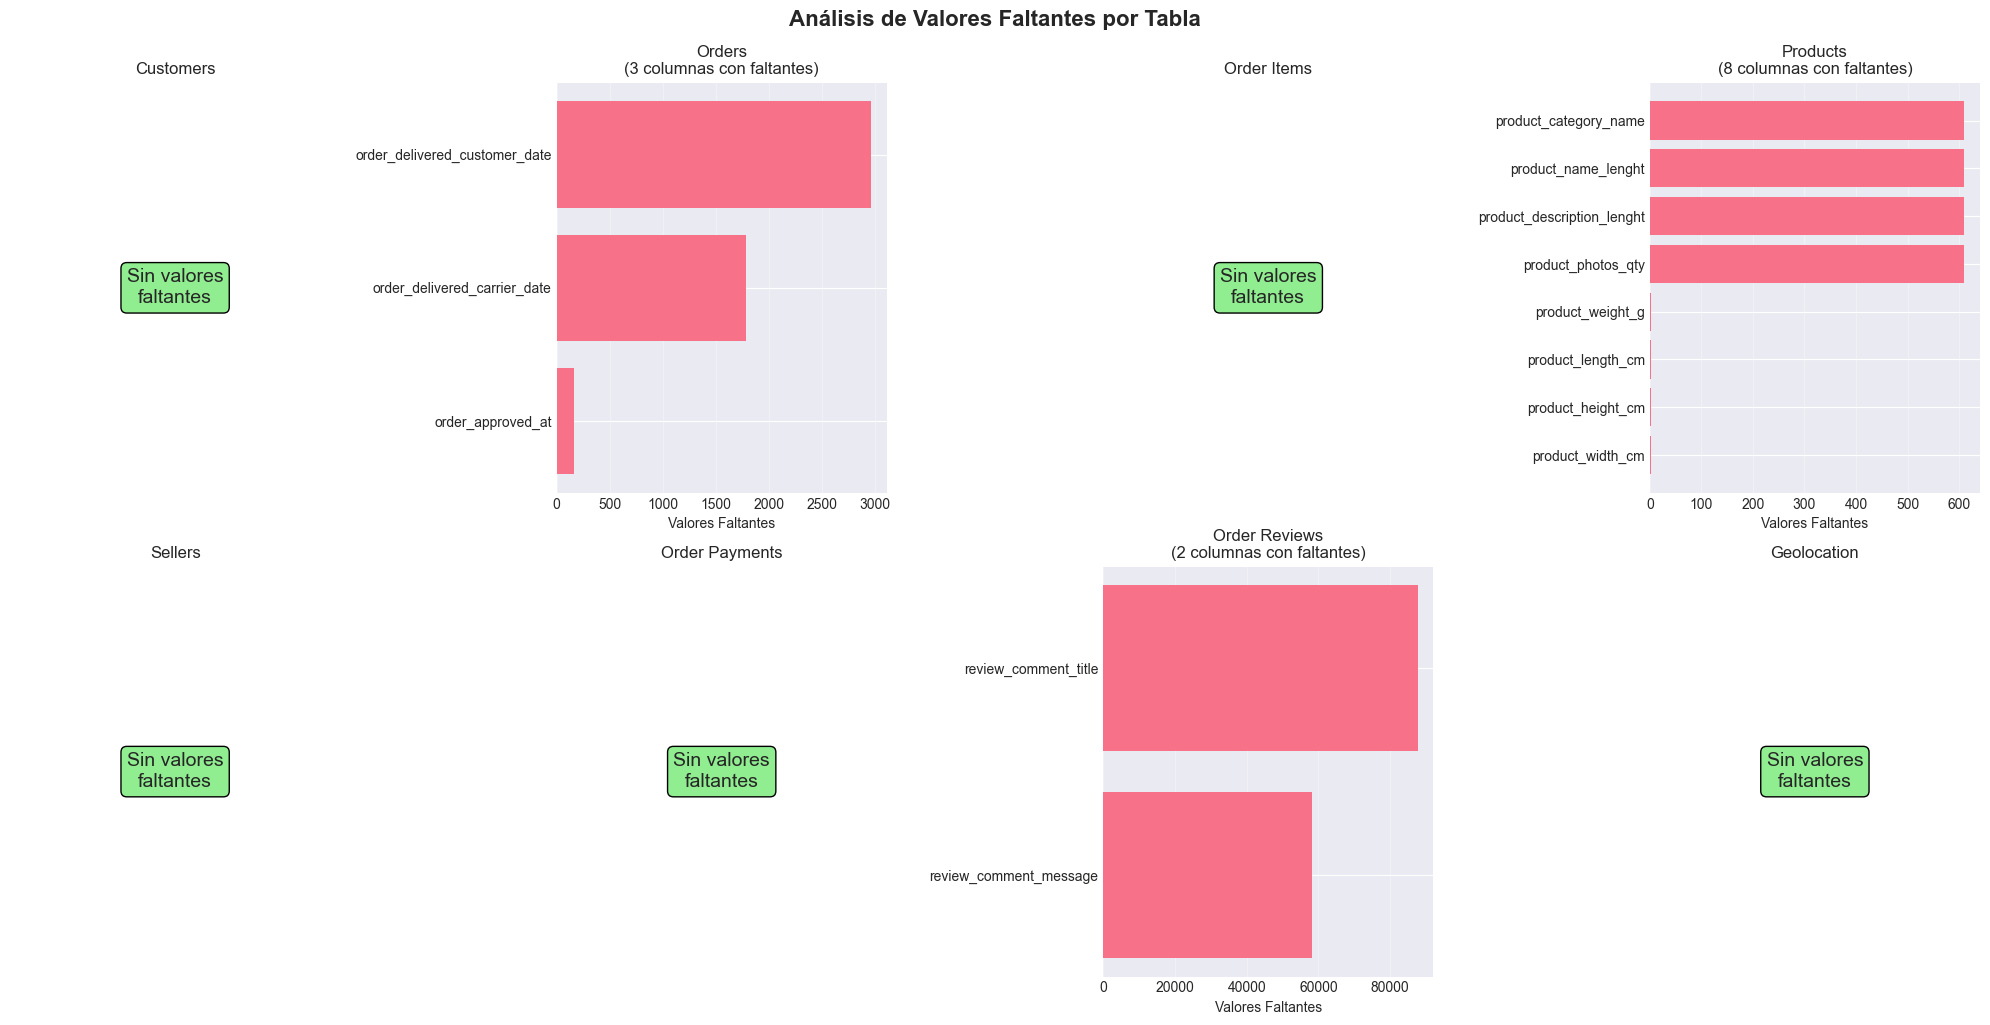

In [11]:
if datasets:
    # Visualización de valores faltantes
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    for idx, (name, df) in enumerate(datasets.items()):
        if idx < len(axes):
            missing = df.isnull().sum()
            missing = missing[missing > 0].sort_values(ascending=True)
            
            if len(missing) > 0:
                axes[idx].barh(range(len(missing)), missing.values)
                axes[idx].set_yticks(range(len(missing)))
                axes[idx].set_yticklabels(missing.index)
                axes[idx].set_xlabel('Valores Faltantes')
                axes[idx].set_title(f'{name.replace("_", " ").title()}\n({len(missing)} columnas con faltantes)')
                axes[idx].grid(axis='x', alpha=0.3)
            else:
                axes[idx].text(0.5, 0.5, 'Sin valores\nfaltantes', 
                              ha='center', va='center', fontsize=14, 
                              bbox=dict(boxstyle='round', facecolor='lightgreen'))
                axes[idx].set_title(f'{name.replace("_", " ").title()}')
                axes[idx].axis('off')
    
    # Ocultar ejes no usados
    for idx in range(len(datasets), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Análisis de Valores Faltantes por Tabla', y=1.02, fontsize=16, fontweight='bold')
    plt.show()
else:
    print("⚠️ No hay datos cargados")


#### Detección de Outliers

Analizamos outliers en variables numéricas clave.


In [12]:
if datasets:
    print("=" * 80)
    print("DETECCIÓN DE OUTLIERS (Método IQR)")
    print("=" * 80)
    
    def detect_outliers_iqr(df, column):
        """Detecta outliers usando el método IQR"""
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        return outliers, lower_bound, upper_bound
    
    # Analizar outliers en tablas con variables numéricas relevantes
    if 'order_items' in datasets:
        df = datasets['order_items']
        if 'price' in df.columns:
            outliers, lower, upper = detect_outliers_iqr(df, 'price')
            print(f"\n💰 PRECIOS (order_items)")
            print(f"   Rango normal: [{lower:.2f}, {upper:.2f}]")
            print(f"   Outliers: {len(outliers):,} ({len(outliers)/len(df)*100:.2f}%)")
            if len(outliers) > 0:
                print(f"   Precio mínimo outlier: R$ {outliers['price'].min():.2f}")
                print(f"   Precio máximo outlier: R$ {outliers['price'].max():.2f}")
        
        if 'freight_value' in df.columns:
            outliers, lower, upper = detect_outliers_iqr(df, 'freight_value')
            print(f"\n🚚 VALOR DE FRETE (order_items)")
            print(f"   Rango normal: [{lower:.2f}, {upper:.2f}]")
            print(f"   Outliers: {len(outliers):,} ({len(outliers)/len(df)*100:.2f}%)")
    
    if 'order_payments' in datasets:
        df = datasets['order_payments']
        if 'payment_value' in df.columns:
            outliers, lower, upper = detect_outliers_iqr(df, 'payment_value')
            print(f"\n💳 VALOR DE PAGO (order_payments)")
            print(f"   Rango normal: [{lower:.2f}, {upper:.2f}]")
            print(f"   Outliers: {len(outliers):,} ({len(outliers)/len(df)*100:.2f}%)")
    
    if 'order_reviews' in datasets:
        df = datasets['order_reviews']
        if 'review_score' in df.columns:
            print(f"\n⭐ REVIEW SCORES (order_reviews)")
            print(f"   Rango: [{df['review_score'].min()}, {df['review_score'].max()}]")
            print(f"   Distribución:")
            print(df['review_score'].value_counts().sort_index())
else:
    print("⚠️ No hay datos cargados")


DETECCIÓN DE OUTLIERS (Método IQR)

💰 PRECIOS (order_items)
   Rango normal: [-102.60, 277.40]
   Outliers: 8,427 (7.48%)
   Precio mínimo outlier: R$ 277.45
   Precio máximo outlier: R$ 6735.00

🚚 VALOR DE FRETE (order_items)
   Rango normal: [0.98, 33.25]
   Outliers: 12,134 (10.77%)

💳 VALOR DE PAGO (order_payments)
   Rango normal: [-115.78, 344.41]
   Outliers: 7,981 (7.68%)

⭐ REVIEW SCORES (order_reviews)
   Rango: [1, 5]
   Distribución:
review_score
1    11424
2     3151
3     8179
4    19142
5    57328
Name: count, dtype: int64


### 3.4 Estadísticas Descriptivas Extensas

Generamos estadísticas descriptivas detalladas para cada tabla.


In [13]:
if datasets:
    print("=" * 80)
    print("ESTADÍSTICAS DESCRIPTIVAS POR TABLA")
    print("=" * 80)
    
    # Estadísticas para cada tabla con variables numéricas
    for name, df in datasets.items():
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        
        if len(numeric_cols) > 0:
            print(f"\n📊 {name.upper().replace('_', ' ')}")
            print("-" * 80)
            display(df[numeric_cols].describe())
            
            # Estadísticas adicionales
            print(f"\n📈 Estadísticas Adicionales:")
            for col in numeric_cols:
                print(f"   {col}:")
                print(f"      • Mediana: {df[col].median():.2f}")
                print(f"      • Moda: {df[col].mode().iloc[0] if len(df[col].mode()) > 0 else 'N/A'}")
                print(f"      • Desviación estándar: {df[col].std():.2f}")
                print(f"      • Coeficiente de variación: {(df[col].std()/df[col].mean()*100):.2f}%")
                print(f"      • Asimetría: {df[col].skew():.2f}")
                print(f"      • Curtosis: {df[col].kurtosis():.2f}")
else:
    print("⚠️ No hay datos cargados")


ESTADÍSTICAS DESCRIPTIVAS POR TABLA

📊 CUSTOMERS
--------------------------------------------------------------------------------


,customer_zip_code_prefix
count,99441.00
mean,35137.47
std,29797.94
min,1003.00
25%,11347.00
50%,24416.00
75%,58900.00
max,99990.00



📈 Estadísticas Adicionales:
   customer_zip_code_prefix:
      • Mediana: 24416.00
      • Moda: 22790
      • Desviación estándar: 29797.94
      • Coeficiente de variación: 84.80%
      • Asimetría: 0.78
      • Curtosis: -0.79

📊 ORDER ITEMS
--------------------------------------------------------------------------------


,order_item_id,price,freight_value
count,112650.00,112650.00,112650.00
mean,1.20,120.65,19.99
std,0.71,183.63,15.81
min,1.00,0.85,0.00
25%,1.00,39.90,13.08
50%,1.00,74.99,16.26
75%,1.00,134.90,21.15
max,21.00,6735.00,409.68



📈 Estadísticas Adicionales:
   order_item_id:
      • Mediana: 1.00
      • Moda: 1
      • Desviación estándar: 0.71
      • Coeficiente de variación: 58.87%
      • Asimetría: 7.58
      • Curtosis: 103.86
   price:
      • Mediana: 74.99
      • Moda: 59.9
      • Desviación estándar: 183.63
      • Coeficiente de variación: 152.20%
      • Asimetría: 7.92
      • Curtosis: 120.83
   freight_value:
      • Mediana: 16.26
      • Moda: 15.1
      • Desviación estándar: 15.81
      • Coeficiente de variación: 79.07%
      • Asimetría: 5.64
      • Curtosis: 59.79

📊 PRODUCTS
--------------------------------------------------------------------------------


,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32341.00,32341.00,32341.00,32949.00,32949.00,32949.00,32949.00
mean,48.48,771.50,2.19,2276.47,30.82,16.94,23.20
std,10.25,635.12,1.74,4282.04,16.91,13.64,12.08
min,5.00,4.00,1.00,0.00,7.00,2.00,6.00
25%,42.00,339.00,1.00,300.00,18.00,8.00,15.00
50%,51.00,595.00,1.00,700.00,25.00,13.00,20.00
75%,57.00,972.00,3.00,1900.00,38.00,21.00,30.00
max,76.00,3992.00,20.00,40425.00,105.00,105.00,118.00



📈 Estadísticas Adicionales:
   product_name_lenght:
      • Mediana: 51.00
      • Moda: 60.0
      • Desviación estándar: 10.25
      • Coeficiente de variación: 21.14%
      • Asimetría: -0.90
      • Curtosis: 0.19
   product_description_lenght:
      • Mediana: 595.00
      • Moda: 404.0
      • Desviación estándar: 635.12
      • Coeficiente de variación: 82.32%
      • Asimetría: 1.96
      • Curtosis: 4.83
   product_photos_qty:
      • Mediana: 1.00
      • Moda: 1.0
      • Desviación estándar: 1.74
      • Coeficiente de variación: 79.34%
      • Asimetría: 2.19
      • Curtosis: 7.26
   product_weight_g:
      • Mediana: 700.00
      • Moda: 200.0
      • Desviación estándar: 4282.04
      • Coeficiente de variación: 188.10%
      • Asimetría: 3.60
      • Curtosis: 15.13
   product_length_cm:
      • Mediana: 25.00
      • Moda: 16.0
      • Desviación estándar: 16.91
      • Coeficiente de variación: 54.89%
      • Asimetría: 1.75
      • Curtosis: 3.51
   product_height_

,seller_zip_code_prefix
count,3095.00
mean,32291.06
std,32713.45
min,1001.00
25%,7093.50
50%,14940.00
75%,64552.50
max,99730.00



📈 Estadísticas Adicionales:
   seller_zip_code_prefix:
      • Mediana: 14940.00
      • Moda: 14940
      • Desviación estándar: 32713.45
      • Coeficiente de variación: 101.31%
      • Asimetría: 0.92
      • Curtosis: -0.86

📊 ORDER PAYMENTS
--------------------------------------------------------------------------------


,payment_sequential,payment_installments,payment_value
count,103886.00,103886.00,103886.00
mean,1.09,2.85,154.10
std,0.71,2.69,217.49
min,1.00,0.00,0.00
25%,1.00,1.00,56.79
50%,1.00,1.00,100.00
75%,1.00,4.00,171.84
max,29.00,24.00,13664.08



📈 Estadísticas Adicionales:
   payment_sequential:
      • Mediana: 1.00
      • Moda: 1
      • Desviación estándar: 0.71
      • Coeficiente de variación: 64.67%
      • Asimetría: 16.18
      • Curtosis: 370.59
   payment_installments:
      • Mediana: 1.00
      • Moda: 1
      • Desviación estándar: 2.69
      • Coeficiente de variación: 94.17%
      • Asimetría: 1.66
      • Curtosis: 2.55
   payment_value:
      • Mediana: 100.00
      • Moda: 50.0
      • Desviación estándar: 217.49
      • Coeficiente de variación: 141.14%
      • Asimetría: 9.25
      • Curtosis: 241.83

📊 ORDER REVIEWS
--------------------------------------------------------------------------------


,review_score
count,99224.00
mean,4.09
std,1.35
min,1.00
25%,4.00
50%,5.00
75%,5.00
max,5.00



📈 Estadísticas Adicionales:
   review_score:
      • Mediana: 5.00
      • Moda: 5
      • Desviación estándar: 1.35
      • Coeficiente de variación: 32.98%
      • Asimetría: -1.36
      • Curtosis: 0.51

📊 GEOLOCATION
--------------------------------------------------------------------------------


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
count,1000163.00,1000163.00,1000163.00
mean,36574.17,-21.18,-46.39
std,30549.34,5.72,4.27
min,1001.00,-36.61,-101.47
25%,11075.00,-23.60,-48.57
50%,26530.00,-22.92,-46.64
75%,63504.00,-19.98,-43.77
max,99990.00,45.07,121.11



📈 Estadísticas Adicionales:
   geolocation_zip_code_prefix:
      • Mediana: 26530.00
      • Moda: 24220
      • Desviación estándar: 30549.34
      • Coeficiente de variación: 83.53%
      • Asimetría: 0.69
      • Curtosis: -0.94
   geolocation_lat:
      • Mediana: -22.92
      • Moda: -27.102098999999946
      • Desviación estándar: 5.72
      • Coeficiente de variación: -26.99%
      • Asimetría: 1.57
      • Curtosis: 2.85
   geolocation_lng:
      • Mediana: -46.64
      • Moda: -48.62961349999995
      • Desviación estándar: 4.27
      • Coeficiente de variación: -9.20%
      • Asimetría: -0.10
      • Curtosis: 4.73


#### Métricas Agregadas del Dataset

Calculamos métricas generales que caracterizan todo el dataset.


In [14]:
if datasets:
    print("=" * 80)
    print("MÉTRICAS AGREGADAS DEL DATASET")
    print("=" * 80)
    
    metrics = {}
    
    # Total de órdenes
    if 'orders' in datasets:
        total_orders = len(datasets['orders'])
        metrics['Total de Órdenes'] = f"{total_orders:,}"
        
        # Rango de fechas
        if 'order_purchase_timestamp' in datasets['orders'].columns:
            dates = pd.to_datetime(datasets['orders']['order_purchase_timestamp'], errors='coerce')
            dates = dates.dropna()
            if len(dates) > 0:
                metrics['Fecha Más Antigua'] = dates.min().strftime('%Y-%m-%d')
                metrics['Fecha Más Reciente'] = dates.max().strftime('%Y-%m-%d')
                metrics['Rango Temporal'] = f"{(dates.max() - dates.min()).days} días"
    
    # Total de clientes únicos
    if 'customers' in datasets:
        metrics['Total de Clientes Únicos'] = f"{len(datasets['customers']):,}"
    
    # Total de vendedores únicos
    if 'sellers' in datasets:
        metrics['Total de Vendedores Únicos'] = f"{len(datasets['sellers']):,}"
    
    # Total de productos únicos
    if 'products' in datasets:
        metrics['Total de Productos Únicos'] = f"{len(datasets['products']):,}"
    
    # Total de items
    if 'order_items' in datasets:
        total_items = len(datasets['order_items'])
        metrics['Total de Items Vendidos'] = f"{total_items:,}"
        
        # Valor total
        if 'price' in datasets['order_items'].columns:
            total_value = datasets['order_items']['price'].sum()
            metrics['Valor Total de Ventas'] = f"R$ {total_value:,.2f}"
            avg_order_value = total_value / total_orders if total_orders > 0 else 0
            metrics['Valor Promedio por Orden'] = f"R$ {avg_order_value:,.2f}"
    
    # Reviews
    if 'order_reviews' in datasets:
        total_reviews = len(datasets['order_reviews'])
        metrics['Total de Reviews'] = f"{total_reviews:,}"
        
        if 'review_score' in datasets['order_reviews'].columns:
            avg_score = datasets['order_reviews']['review_score'].mean()
            metrics['Review Score Promedio'] = f"{avg_score:.2f}"
    
    # Mostrar métricas
    print("\n")
    for key, value in metrics.items():
        print(f"📊 {key}: {value}")
    
    # Crear DataFrame para visualización
    metrics_df = pd.DataFrame(list(metrics.items()), columns=['Métrica', 'Valor'])
    print("\n")
    display(metrics_df)
else:
    print("⚠️ No hay datos cargados")


MÉTRICAS AGREGADAS DEL DATASET


📊 Total de Órdenes: 99,441
📊 Fecha Más Antigua: 2016-09-04
📊 Fecha Más Reciente: 2018-10-17
📊 Rango Temporal: 772 días
📊 Total de Clientes Únicos: 99,441
📊 Total de Vendedores Únicos: 3,095
📊 Total de Productos Únicos: 32,951
📊 Total de Items Vendidos: 112,650
📊 Valor Total de Ventas: R$ 13,591,643.70
📊 Valor Promedio por Orden: R$ 136.68
📊 Total de Reviews: 99,224
📊 Review Score Promedio: 4.09




,Métrica,Valor
0,Total de Órdenes,"99,441"
1,Fecha Más Antigua,2016-09-04
2,Fecha Más Reciente,2018-10-17
3,Rango Temporal,772 días
4,Total de Clientes Únicos,"99,441"
5,Total de Vendedores Únicos,"3,095"
6,Total de Productos Únicos,"32,951"
7,Total de Items Vendidos,"112,650"
8,Valor Total de Ventas,"R$ 13,591,643.70"
9,Valor Promedio por Orden,R$ 136.68


### 3.5 Análisis Exploratorio Inicial

Realizamos un análisis exploratorio inicial para identificar patrones, tendencias y relaciones en los datos.


#### 3.5.1 Análisis Temporal

Analizamos la evolución de las órdenes en el tiempo y patrones estacionales.


In [15]:
if datasets and 'orders' in datasets:
    # Preparar datos temporales
    orders_df = datasets['orders'].copy()
    
    # Convertir fechas
    date_cols = [col for col in orders_df.columns if 'timestamp' in col or 'date' in col]
    for col in date_cols:
        orders_df[col] = pd.to_datetime(orders_df[col], errors='coerce')
    
    if 'order_purchase_timestamp' in orders_df.columns:
        orders_df = orders_df.dropna(subset=['order_purchase_timestamp'])
        orders_df['year'] = orders_df['order_purchase_timestamp'].dt.year
        orders_df['month'] = orders_df['order_purchase_timestamp'].dt.month
        orders_df['day_of_week'] = orders_df['order_purchase_timestamp'].dt.day_name()
        orders_df['day_of_week_num'] = orders_df['order_purchase_timestamp'].dt.dayofweek
        orders_df['date'] = orders_df['order_purchase_timestamp'].dt.date
        
        # Estadísticas temporales
        print("=" * 80)
        print("ANÁLISIS TEMPORAL")
        print("=" * 80)
        
        print(f"\n📅 Distribución por Año:")
        print(orders_df['year'].value_counts().sort_index())
        
        print(f"\n📅 Distribución por Mes:")
        month_names = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
                      'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
        month_dist = orders_df['month'].value_counts().sort_index()
        for month, count in month_dist.items():
            print(f"   {month_names[month-1]}: {count:,} órdenes")
        
        print(f"\n📅 Distribución por Día de la Semana:")
        day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        day_dist = orders_df['day_of_week'].value_counts()
        for day in day_order:
            if day in day_dist.index:
                print(f"   {day}: {day_dist[day]:,} órdenes")
        
        # Órdenes por fecha
        orders_by_date = orders_df.groupby('date').size().reset_index(name='orders')
        orders_by_date['date'] = pd.to_datetime(orders_by_date['date'])
        
        print(f"\n📈 Estadísticas Diarias:")
        print(f"   Promedio de órdenes por día: {orders_by_date['orders'].mean():.2f}")
        print(f"   Máximo de órdenes en un día: {orders_by_date['orders'].max()}")
        print(f"   Mínimo de órdenes en un día: {orders_by_date['orders'].min()}")
        print(f"   Desviación estándar: {orders_by_date['orders'].std():.2f}")
    else:
        print("⚠️ No se encontró la columna 'order_purchase_timestamp'")
else:
    print("⚠️ No hay datos de órdenes cargados")


ANÁLISIS TEMPORAL

📅 Distribución por Año:
year
2016      329
2017    45101
2018    54011
Name: count, dtype: int64

📅 Distribución por Mes:
   Ene: 8,069 órdenes
   Feb: 8,508 órdenes
   Mar: 9,893 órdenes
   Abr: 9,343 órdenes
   May: 10,573 órdenes
   Jun: 9,412 órdenes
   Jul: 10,318 órdenes
   Ago: 10,843 órdenes
   Sep: 4,305 órdenes
   Oct: 4,959 órdenes
   Nov: 7,544 órdenes
   Dic: 5,674 órdenes

📅 Distribución por Día de la Semana:
   Monday: 16,196 órdenes
   Tuesday: 15,963 órdenes
   Wednesday: 15,552 órdenes
   Thursday: 14,761 órdenes
   Friday: 14,122 órdenes
   Saturday: 10,887 órdenes
   Sunday: 11,960 órdenes

📈 Estadísticas Diarias:
   Promedio de órdenes por día: 156.85
   Máximo de órdenes en un día: 1176
   Mínimo de órdenes en un día: 1
   Desviación estándar: 94.22


#### 3.5.2 Análisis Geográfico

Analizamos la distribución geográfica de clientes, vendedores y órdenes.


In [16]:
if datasets:
    print("=" * 80)
    print("ANÁLISIS GEOGRÁFICO")
    print("=" * 80)
    
    # Análisis de clientes por estado
    if 'customers' in datasets:
        customers_df = datasets['customers']
        if 'customer_state' in customers_df.columns:
            print(f"\n👥 DISTRIBUCIÓN DE CLIENTES POR ESTADO")
            print("-" * 80)
            customer_by_state = customers_df['customer_state'].value_counts().head(10)
            for state, count in customer_by_state.items():
                pct = count / len(customers_df) * 100
                print(f"   {state}: {count:,} clientes ({pct:.2f}%)")
    
    # Análisis de vendedores por estado
    if 'sellers' in datasets:
        sellers_df = datasets['sellers']
        if 'seller_state' in sellers_df.columns:
            print(f"\n🏪 DISTRIBUCIÓN DE VENDEDORES POR ESTADO")
            print("-" * 80)
            seller_by_state = sellers_df['seller_state'].value_counts().head(10)
            for state, count in seller_by_state.items():
                pct = count / len(sellers_df) * 100
                print(f"   {state}: {count:,} vendedores ({pct:.2f}%)")
    
    # Órdenes por estado (combinando customers y orders)
    if 'orders' in datasets and 'customers' in datasets:
        orders_df = datasets['orders']
        customers_df = datasets['customers']
        
        if 'customer_id' in orders_df.columns and 'customer_id' in customers_df.columns:
            orders_with_state = orders_df.merge(
                customers_df[['customer_id', 'customer_state']], 
                on='customer_id', 
                how='left'
            )
            
            if 'customer_state' in orders_with_state.columns:
                print(f"\n🛒 DISTRIBUCIÓN DE ÓRDENES POR ESTADO")
                print("-" * 80)
                orders_by_state = orders_with_state['customer_state'].value_counts().head(10)
                for state, count in orders_by_state.items():
                    pct = count / len(orders_with_state) * 100
                    print(f"   {state}: {count:,} órdenes ({pct:.2f}%)")
else:
    print("⚠️ No hay datos cargados")


ANÁLISIS GEOGRÁFICO

👥 DISTRIBUCIÓN DE CLIENTES POR ESTADO
--------------------------------------------------------------------------------
   SP: 41,746 clientes (41.98%)
   RJ: 12,852 clientes (12.92%)
   MG: 11,635 clientes (11.70%)
   RS: 5,466 clientes (5.50%)
   PR: 5,045 clientes (5.07%)
   SC: 3,637 clientes (3.66%)
   BA: 3,380 clientes (3.40%)
   DF: 2,140 clientes (2.15%)
   ES: 2,033 clientes (2.04%)
   GO: 2,020 clientes (2.03%)

🏪 DISTRIBUCIÓN DE VENDEDORES POR ESTADO
--------------------------------------------------------------------------------
   SP: 1,849 vendedores (59.74%)
   PR: 349 vendedores (11.28%)
   MG: 244 vendedores (7.88%)
   SC: 190 vendedores (6.14%)
   RJ: 171 vendedores (5.53%)
   RS: 129 vendedores (4.17%)
   GO: 40 vendedores (1.29%)
   DF: 30 vendedores (0.97%)
   ES: 23 vendedores (0.74%)
   BA: 19 vendedores (0.61%)

🛒 DISTRIBUCIÓN DE ÓRDENES POR ESTADO
--------------------------------------------------------------------------------
   SP: 41,746

#### 3.5.3 Análisis de Productos

Analizamos las categorías de productos, precios y productos más vendidos.


In [17]:
if datasets:
    print("=" * 80)
    print("ANÁLISIS DE PRODUCTOS")
    print("=" * 80)
    
    # Análisis de categorías
    if 'products' in datasets:
        products_df = datasets['products']
        
        if 'product_category_name' in products_df.columns:
            print(f"\n📦 DISTRIBUCIÓN DE CATEGORÍAS DE PRODUCTOS")
            print("-" * 80)
            category_dist = products_df['product_category_name'].value_counts().head(15)
            for category, count in category_dist.items():
                pct = count / len(products_df) * 100
                print(f"   {category}: {count:,} productos ({pct:.2f}%)")
        
        # Análisis de dimensiones y peso
        numeric_cols = ['product_length_cm', 'product_height_cm', 'product_width_cm', 'product_weight_g']
        existing_cols = [col for col in numeric_cols if col in products_df.columns]
        
        if existing_cols:
            print(f"\n📏 ESTADÍSTICAS DE DIMENSIONES Y PESO")
            print("-" * 80)
            display(products_df[existing_cols].describe())
    
    # Productos más vendidos (combinando products y order_items)
    if 'order_items' in datasets and 'products' in datasets:
        items_df = datasets['order_items']
        products_df = datasets['products']
        
        # Merge
        items_with_products = items_df.merge(
            products_df[['product_id', 'product_category_name']], 
            on='product_id', 
            how='left'
        )
        
        # Top categorías por volumen de ventas
        if 'product_category_name' in items_with_products.columns:
            print(f"\n🏆 TOP 15 CATEGORÍAS POR VOLUMEN DE VENTAS")
            print("-" * 80)
            category_sales = items_with_products.groupby('product_category_name').agg({
                'order_id': 'count',
                'price': 'sum'
            }).rename(columns={'order_id': 'cantidad_items', 'price': 'revenue'})
            category_sales = category_sales.sort_values('cantidad_items', ascending=False).head(15)
            
            for category, row in category_sales.iterrows():
                print(f"   {category}:")
                print(f"      • Items vendidos: {row['cantidad_items']:,}")
                print(f"      • Ingresos: R$ {row['revenue']:,.2f}")
        
        # Estadísticas de precios
        if 'price' in items_df.columns:
            print(f"\n💰 ESTADÍSTICAS DE PRECIOS")
            print("-" * 80)
            print(f"   Precio promedio: R$ {items_df['price'].mean():.2f}")
            print(f"   Precio mediano: R$ {items_df['price'].median():.2f}")
            print(f"   Precio mínimo: R$ {items_df['price'].min():.2f}")
            print(f"   Precio máximo: R$ {items_df['price'].max():.2f}")
            print(f"   Desviación estándar: R$ {items_df['price'].std():.2f}")
else:
    print("⚠️ No hay datos cargados")


ANÁLISIS DE PRODUCTOS

📦 DISTRIBUCIÓN DE CATEGORÍAS DE PRODUCTOS
--------------------------------------------------------------------------------
   cama_mesa_banho: 3,029 productos (9.19%)
   esporte_lazer: 2,867 productos (8.70%)
   moveis_decoracao: 2,657 productos (8.06%)
   beleza_saude: 2,444 productos (7.42%)
   utilidades_domesticas: 2,335 productos (7.09%)
   automotivo: 1,900 productos (5.77%)
   informatica_acessorios: 1,639 productos (4.97%)
   brinquedos: 1,411 productos (4.28%)
   relogios_presentes: 1,329 productos (4.03%)
   telefonia: 1,134 productos (3.44%)
   bebes: 919 productos (2.79%)
   perfumaria: 868 productos (2.63%)
   papelaria: 849 productos (2.58%)
   fashion_bolsas_e_acessorios: 849 productos (2.58%)
   cool_stuff: 789 productos (2.39%)

📏 ESTADÍSTICAS DE DIMENSIONES Y PESO
--------------------------------------------------------------------------------


,product_length_cm,product_height_cm,product_width_cm,product_weight_g
count,32949.00,32949.00,32949.00,32949.00
mean,30.82,16.94,23.20,2276.47
std,16.91,13.64,12.08,4282.04
min,7.00,2.00,6.00,0.00
25%,18.00,8.00,15.00,300.00
50%,25.00,13.00,20.00,700.00
75%,38.00,21.00,30.00,1900.00
max,105.00,105.00,118.00,40425.00



🏆 TOP 15 CATEGORÍAS POR VOLUMEN DE VENTAS
--------------------------------------------------------------------------------
   cama_mesa_banho:
      • Items vendidos: 11,115.0
      • Ingresos: R$ 1,036,988.68
   beleza_saude:
      • Items vendidos: 9,670.0
      • Ingresos: R$ 1,258,681.34
   esporte_lazer:
      • Items vendidos: 8,641.0
      • Ingresos: R$ 988,048.97
   moveis_decoracao:
      • Items vendidos: 8,334.0
      • Ingresos: R$ 729,762.49
   informatica_acessorios:
      • Items vendidos: 7,827.0
      • Ingresos: R$ 911,954.32
   utilidades_domesticas:
      • Items vendidos: 6,964.0
      • Ingresos: R$ 632,248.66
   relogios_presentes:
      • Items vendidos: 5,991.0
      • Ingresos: R$ 1,205,005.68
   telefonia:
      • Items vendidos: 4,545.0
      • Ingresos: R$ 323,667.53
   ferramentas_jardim:
      • Items vendidos: 4,347.0
      • Ingresos: R$ 485,256.46
   automotivo:
      • Items vendidos: 4,235.0
      • Ingresos: R$ 592,720.11
   brinquedos:
      • It

#### 3.5.4 Análisis de Clientes

Analizamos patrones de comportamiento de los clientes.


In [18]:
if datasets and 'orders' in datasets and 'customers' in datasets:
    print("=" * 80)
    print("ANÁLISIS DE CLIENTES")
    print("=" * 80)
    
    orders_df = datasets['orders']
    customers_df = datasets['customers']
    
    # Frecuencia de compras por cliente
    orders_per_customer = orders_df['customer_id'].value_counts()
    
    print(f"\n🛒 FRECUENCIA DE COMPRAS")
    print("-" * 80)
    print(f"   Total de clientes únicos: {len(customers_df):,}")
    print(f"   Total de órdenes: {len(orders_df):,}")
    print(f"   Promedio de órdenes por cliente: {orders_per_customer.mean():.2f}")
    print(f"   Mediana de órdenes por cliente: {orders_per_customer.median():.2f}")
    print(f"   Máximo de órdenes por un cliente: {orders_per_customer.max()}")
    
    # Clientes únicos vs recurrentes
    unique_customers = (orders_per_customer == 1).sum()
    repeat_customers = (orders_per_customer > 1).sum()
    
    print(f"\n👥 CLIENTES ÚNICOS VS RECURRENTES")
    print("-" * 80)
    print(f"   Clientes con 1 orden: {unique_customers:,} ({unique_customers/len(orders_per_customer)*100:.2f}%)")
    print(f"   Clientes con 2+ órdenes: {repeat_customers:,} ({repeat_customers/len(orders_per_customer)*100:.2f}%)")
    
    # Distribución de frecuencia
    freq_dist = orders_per_customer.value_counts().sort_index().head(10)
    print(f"\n📊 DISTRIBUCIÓN DE FRECUENCIA DE COMPRAS")
    print("-" * 80)
    for freq, count in freq_dist.items():
        print(f"   {freq} orden(es): {count:,} clientes")
else:
    print("⚠️ No hay datos de órdenes o clientes cargados")


ANÁLISIS DE CLIENTES

🛒 FRECUENCIA DE COMPRAS
--------------------------------------------------------------------------------
   Total de clientes únicos: 99,441
   Total de órdenes: 99,441
   Promedio de órdenes por cliente: 1.00
   Mediana de órdenes por cliente: 1.00
   Máximo de órdenes por un cliente: 1

👥 CLIENTES ÚNICOS VS RECURRENTES
--------------------------------------------------------------------------------
   Clientes con 1 orden: 99,441 (100.00%)
   Clientes con 2+ órdenes: 0 (0.00%)

📊 DISTRIBUCIÓN DE FRECUENCIA DE COMPRAS
--------------------------------------------------------------------------------
   1 orden(es): 99,441 clientes


#### 3.5.5 Análisis de Vendedores

Analizamos el desempeño y distribución de vendedores.


In [19]:
if datasets and 'order_items' in datasets and 'sellers' in datasets:
    print("=" * 80)
    print("ANÁLISIS DE VENDEDORES")
    print("=" * 80)
    
    items_df = datasets['order_items']
    sellers_df = datasets['sellers']
    
    # Vendedores por volumen de ventas
    seller_performance = items_df.groupby('seller_id').agg({
        'order_id': 'count',
        'price': 'sum'
    }).rename(columns={'order_id': 'total_items', 'price': 'total_revenue'})
    seller_performance = seller_performance.sort_values('total_revenue', ascending=False)
    
    print(f"\n🏪 ESTADÍSTICAS GENERALES")
    print("-" * 80)
    print(f"   Total de vendedores únicos: {len(sellers_df):,}")
    print(f"   Vendedores activos (con ventas): {len(seller_performance):,}")
    print(f"   Promedio de items vendidos por vendedor: {seller_performance['total_items'].mean():.2f}")
    print(f"   Promedio de ingresos por vendedor: R$ {seller_performance['total_revenue'].mean():,.2f}")
    
    # Top vendedores
    print(f"\n🏆 TOP 10 VENDEDORES POR INGRESOS")
    print("-" * 80)
    top_sellers = seller_performance.head(10)
    for idx, (seller_id, row) in enumerate(top_sellers.iterrows(), 1):
        print(f"   {idx}. {seller_id}:")
        print(f"      • Items vendidos: {row['total_items']:,}")
        print(f"      • Ingresos: R$ {row['total_revenue']:,.2f}")
    
    # Distribución de ventas
    print(f"\n📊 DISTRIBUCIÓN DE VENTAS POR VENDEDOR")
    print("-" * 80)
    print(f"   Mediana de items por vendedor: {seller_performance['total_items'].median():.2f}")
    print(f"   Mediana de ingresos por vendedor: R$ {seller_performance['total_revenue'].median():,.2f}")
    print(f"   Vendedor con más items: {seller_performance['total_items'].max():,} items")
    print(f"   Vendedor con más ingresos: R$ {seller_performance['total_revenue'].max():,.2f}")
else:
    print("⚠️ No hay datos de items o vendedores cargados")


ANÁLISIS DE VENDEDORES

🏪 ESTADÍSTICAS GENERALES
--------------------------------------------------------------------------------
   Total de vendedores únicos: 3,095
   Vendedores activos (con ventas): 3,095
   Promedio de items vendidos por vendedor: 36.40
   Promedio de ingresos por vendedor: R$ 4,391.48

🏆 TOP 10 VENDEDORES POR INGRESOS
--------------------------------------------------------------------------------
   1. 4869f7a5dfa277a7dca6462dcf3b52b2:
      • Items vendidos: 1,156.0
      • Ingresos: R$ 229,472.63
   2. 53243585a1d6dc2643021fd1853d8905:
      • Items vendidos: 410.0
      • Ingresos: R$ 222,776.05
   3. 4a3ca9315b744ce9f8e9374361493884:
      • Items vendidos: 1,987.0
      • Ingresos: R$ 200,472.92
   4. fa1c13f2614d7b5c4749cbc52fecda94:
      • Items vendidos: 586.0
      • Ingresos: R$ 194,042.03
   5. 7c67e1448b00f6e969d365cea6b010ab:
      • Items vendidos: 1,364.0
      • Ingresos: R$ 187,923.89
   6. 7e93a43ef30c4f03f38b393420bc753a:
      • Items vendid

#### 3.5.6 Análisis de Pagos

Analizamos métodos de pago, valores y patrones de pago.


In [20]:
if datasets and 'order_payments' in datasets:
    print("=" * 80)
    print("ANÁLISIS DE PAGOS")
    print("=" * 80)
    
    payments_df = datasets['order_payments']
    
    # Métodos de pago
    if 'payment_type' in payments_df.columns:
        print(f"\n💳 DISTRIBUCIÓN DE MÉTODOS DE PAGO")
        print("-" * 80)
        payment_methods = payments_df['payment_type'].value_counts()
        for method, count in payment_methods.items():
            pct = count / len(payments_df) * 100
            print(f"   {method}: {count:,} pagos ({pct:.2f}%)")
    
    # Valores de pago
    if 'payment_value' in payments_df.columns:
        print(f"\n💰 ESTADÍSTICAS DE VALORES DE PAGO")
        print("-" * 80)
        print(f"   Valor total pagado: R$ {payments_df['payment_value'].sum():,.2f}")
        print(f"   Valor promedio por pago: R$ {payments_df['payment_value'].mean():.2f}")
        print(f"   Valor mediano por pago: R$ {payments_df['payment_value'].median():.2f}")
        print(f"   Valor mínimo: R$ {payments_df['payment_value'].min():.2f}")
        print(f"   Valor máximo: R$ {payments_df['payment_value'].max():.2f}")
    
    # Número de cuotas (installments)
    if 'payment_installments' in payments_df.columns:
        print(f"\n📅 ANÁLISIS DE CUOTAS")
        print("-" * 80)
        installments_dist = payments_df['payment_installments'].value_counts().sort_index().head(15)
        print(f"   Distribución de número de cuotas:")
        for installments, count in installments_dist.items():
            pct = count / len(payments_df) * 100
            print(f"   {installments} cuota(s): {count:,} pagos ({pct:.2f}%)")
        print(f"   Promedio de cuotas: {payments_df['payment_installments'].mean():.2f}")
        print(f"   Mediana de cuotas: {payments_df['payment_installments'].median():.2f}")
        print(f"   Máximo de cuotas: {payments_df['payment_installments'].max()}")
    
    # Relación método de pago y valor
    if 'payment_type' in payments_df.columns and 'payment_value' in payments_df.columns:
        print(f"\n💳 VALOR PROMEDIO POR MÉTODO DE PAGO")
        print("-" * 80)
        payment_by_type = payments_df.groupby('payment_type')['payment_value'].agg(['mean', 'median', 'sum', 'count'])
        for payment_type, row in payment_by_type.iterrows():
            print(f"   {payment_type}:")
            print(f"      • Valor promedio: R$ {row['mean']:,.2f}")
            print(f"      • Valor mediano: R$ {row['median']:,.2f}")
            print(f"      • Valor total: R$ {row['sum']:,.2f}")
            print(f"      • Cantidad de pagos: {row['count']:,}")
else:
    print("⚠️ No hay datos de pagos cargados")


ANÁLISIS DE PAGOS

💳 DISTRIBUCIÓN DE MÉTODOS DE PAGO
--------------------------------------------------------------------------------
   credit_card: 76,795 pagos (73.92%)
   boleto: 19,784 pagos (19.04%)
   voucher: 5,775 pagos (5.56%)
   debit_card: 1,529 pagos (1.47%)
   not_defined: 3 pagos (0.00%)

💰 ESTADÍSTICAS DE VALORES DE PAGO
--------------------------------------------------------------------------------
   Valor total pagado: R$ 16,008,872.12
   Valor promedio por pago: R$ 154.10
   Valor mediano por pago: R$ 100.00
   Valor mínimo: R$ 0.00
   Valor máximo: R$ 13664.08

📅 ANÁLISIS DE CUOTAS
--------------------------------------------------------------------------------
   Distribución de número de cuotas:
   0 cuota(s): 2 pagos (0.00%)
   1 cuota(s): 52,546 pagos (50.58%)
   2 cuota(s): 12,413 pagos (11.95%)
   3 cuota(s): 10,461 pagos (10.07%)
   4 cuota(s): 7,098 pagos (6.83%)
   5 cuota(s): 5,239 pagos (5.04%)
   6 cuota(s): 3,920 pagos (3.77%)
   7 cuota(s): 1,626 pag

#### 3.5.7 Análisis de Reviews

Analizamos las calificaciones y comentarios de los clientes.


In [21]:
if datasets and 'order_reviews' in datasets:
    print("=" * 80)
    print("ANÁLISIS DE REVIEWS")
    print("=" * 80)
    
    reviews_df = datasets['order_reviews']
    
    # Distribución de review scores
    if 'review_score' in reviews_df.columns:
        print(f"\n⭐ DISTRIBUCIÓN DE REVIEW SCORES")
        print("-" * 80)
        score_dist = reviews_df['review_score'].value_counts().sort_index()
        total_reviews = len(reviews_df)
        
        for score, count in score_dist.items():
            pct = count / total_reviews * 100
            bar = '█' * int(pct / 2)  # Barra visual
            print(f"   {score} estrellas: {count:,} reviews ({pct:.2f}%) {bar}")
        
        print(f"\n📊 ESTADÍSTICAS DE REVIEW SCORES")
        print("-" * 80)
        print(f"   Total de reviews: {total_reviews:,}")
        print(f"   Score promedio: {reviews_df['review_score'].mean():.2f}")
        print(f"   Score mediano: {reviews_df['review_score'].median():.2f}")
        print(f"   Score mínimo: {reviews_df['review_score'].min()}")
        print(f"   Score máximo: {reviews_df['review_score'].max()}")
        print(f"   Desviación estándar: {reviews_df['review_score'].std():.2f}")
        
        # Clasificación de satisfacción
        positive = (reviews_df['review_score'] >= 4).sum()
        neutral = (reviews_df['review_score'] == 3).sum()
        negative = (reviews_df['review_score'] <= 2).sum()
        
        print(f"\n😊 CLASIFICACIÓN DE SATISFACCIÓN")
        print("-" * 80)
        print(f"   Positivas (4-5 estrellas): {positive:,} ({positive/total_reviews*100:.2f}%)")
        print(f"   Neutrales (3 estrellas): {neutral:,} ({neutral/total_reviews*100:.2f}%)")
        print(f"   Negativas (1-2 estrellas): {negative:,} ({negative/total_reviews*100:.2f}%)")
    
    # Análisis de comentarios (si existen)
    if 'review_comment_message' in reviews_df.columns:
        total_comments = reviews_df['review_comment_message'].notna().sum()
        print(f"\n💬 COMENTARIOS")
        print("-" * 80)
        print(f"   Reviews con comentarios: {total_comments:,} ({total_comments/len(reviews_df)*100:.2f}%)")
        print(f"   Reviews sin comentarios: {(len(reviews_df) - total_comments):,} ({(len(reviews_df) - total_comments)/len(reviews_df)*100:.2f}%)")
        
        # Longitud promedio de comentarios
        if total_comments > 0:
            comments_length = reviews_df['review_comment_message'].dropna().str.len()
            print(f"   Longitud promedio de comentarios: {comments_length.mean():.0f} caracteres")
            print(f"   Longitud mediana: {comments_length.median():.0f} caracteres")
else:
    print("⚠️ No hay datos de reviews cargados")


ANÁLISIS DE REVIEWS

⭐ DISTRIBUCIÓN DE REVIEW SCORES
--------------------------------------------------------------------------------
   1 estrellas: 11,424 reviews (11.51%) █████
   2 estrellas: 3,151 reviews (3.18%) █
   3 estrellas: 8,179 reviews (8.24%) ████
   4 estrellas: 19,142 reviews (19.29%) █████████
   5 estrellas: 57,328 reviews (57.78%) ████████████████████████████

📊 ESTADÍSTICAS DE REVIEW SCORES
--------------------------------------------------------------------------------
   Total de reviews: 99,224
   Score promedio: 4.09
   Score mediano: 5.00
   Score mínimo: 1
   Score máximo: 5
   Desviación estándar: 1.35

😊 CLASIFICACIÓN DE SATISFACCIÓN
--------------------------------------------------------------------------------
   Positivas (4-5 estrellas): 76,470 (77.07%)
   Neutrales (3 estrellas): 8,179 (8.24%)
   Negativas (1-2 estrellas): 14,575 (14.69%)

💬 COMENTARIOS
--------------------------------------------------------------------------------
   Reviews con com

#### 3.5.8 Análisis de Entregas

Analizamos tiempos de entrega, estados de entrega y retrasos.


In [ ]:
if datasets and 'orders' in datasets:
    print("=" * 80)
    print("ANÁLISIS DE ENTREGAS")
    print("=" * 80)

    orders_df = datasets['orders'].copy()

    # Convertir TODAS las columnas de fecha a datetime
    date_columns = [
        'order_purchase_timestamp',
        'order_approved_at',
        'order_delivered_carrier_date',
        'order_delivered_customer_date',
        'order_estimated_delivery_date'
    ]
    
    for col in date_columns:
        if col in orders_df.columns:
            orders_df[col] = pd.to_datetime(orders_df[col], errors='coerce')

    # Estados de entrega
    if 'order_status' in orders_df.columns:
        print(f"\n📦 ESTADOS DE ÓRDENES")
        print("-" * 80)
        status_dist = orders_df['order_status'].value_counts()
        for status, count in status_dist.items():
            pct = count / len(orders_df) * 100
            print(f"   {status}: {count:,} órdenes ({pct:.2f}%)")

    # Cálculo de tiempos de entrega (desde compra hasta entrega al cliente)
    if 'order_delivered_customer_date' in orders_df.columns and 'order_purchase_timestamp' in orders_df.columns:
        orders_df['delivery_time'] = (
            orders_df['order_delivered_customer_date'] -
            orders_df['order_purchase_timestamp']
        ).dt.days

        valid_delivery = orders_df['delivery_time'].dropna()

        if len(valid_delivery) > 0:
            print(f"\n⏱️ TIEMPO DE ENTREGA (Compra → Cliente)")
            print("-" * 80)
            print(f"   Tiempo promedio: {valid_delivery.mean():.2f} días")      
            print(f"   Tiempo mediano: {valid_delivery.median():.2f} días")     
            print(f"   Tiempo mínimo: {valid_delivery.min():.0f} días")
            print(f"   Tiempo máximo: {valid_delivery.max():.0f} días")

    # Tiempo estimado vs real
    if 'order_estimated_delivery_date' in orders_df.columns and 'order_delivered_customer_date' in orders_df.columns:
        orders_df['delivery_delay'] = (
            orders_df['order_delivered_customer_date'] -
            orders_df['order_estimated_delivery_date']
        ).dt.days

        valid_delay = orders_df['delivery_delay'].dropna()

        if len(valid_delay) > 0:
            on_time = (valid_delay <= 0).sum()
            delayed = (valid_delay > 0).sum()

            print(f"\n⏰ CUMPLIMIENTO DE FECHAS ESTIMADAS")
            print("-" * 80)
            print(f"   Entregas a tiempo: {on_time:,} ({on_time/len(valid_delay)*100:.2f}%)")
            print(f"   Entregas con retraso: {delayed:,} ({delayed/len(valid_delay)*100:.2f}%)")
            if delayed > 0:
                print(f"   Retraso promedio: {valid_delay[valid_delay > 0].mean():.2f} días")
            else:
                print("   Sin retrasos")
else:
    print("⚠️ No hay datos de órdenes cargados")


ANÁLISIS DE ENTREGAS

📦 ESTADOS DE ÓRDENES
--------------------------------------------------------------------------------
   delivered: 96,478 órdenes (97.02%)
   shipped: 1,107 órdenes (1.11%)
   canceled: 625 órdenes (0.63%)
   unavailable: 609 órdenes (0.61%)
   invoiced: 314 órdenes (0.32%)
   processing: 301 órdenes (0.30%)
   created: 5 órdenes (0.01%)
   approved: 2 órdenes (0.00%)


TypeError: unsupported operand type(s) for -: 'str' and 'str'

### 3.6 Visualizaciones Descriptivas Extensas

A continuación presentamos múltiples visualizaciones para entender mejor los datos y los patrones que contienen.


#### Visualización 1-4: Análisis Temporal


In [ ]:
if datasets and 'orders' in datasets:
    orders_df = datasets['orders'].copy()
    
    # Preparar datos temporales
    if 'order_purchase_timestamp' in orders_df.columns:
        orders_df['order_purchase_timestamp'] = pd.to_datetime(orders_df['order_purchase_timestamp'], errors='coerce')
        orders_df = orders_df.dropna(subset=['order_purchase_timestamp'])
        orders_df['year_month'] = orders_df['order_purchase_timestamp'].dt.to_period('M')
        orders_df['month'] = orders_df['order_purchase_timestamp'].dt.month
        orders_df['day_of_week'] = orders_df['order_purchase_timestamp'].dt.day_name()
        orders_df['day_of_week_num'] = orders_df['order_purchase_timestamp'].dt.dayofweek
        
        # 1. Línea de tiempo de órdenes por mes
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Gráfica 1: Línea de tiempo mensual
        monthly_orders = orders_df.groupby('year_month').size()
        axes[0, 0].plot(monthly_orders.index.astype(str), monthly_orders.values, marker='o', linewidth=2, markersize=6)
        axes[0, 0].set_title('Evolución de Órdenes por Mes', fontsize=14, fontweight='bold')
        axes[0, 0].set_xlabel('Mes')
        axes[0, 0].set_ylabel('Número de Órdenes')
        axes[0, 0].tick_params(axis='x', rotation=45)
        axes[0, 0].grid(True, alpha=0.3)
        
        # Gráfica 2: Distribución por año
        yearly_orders = orders_df.groupby(orders_df['order_purchase_timestamp'].dt.year).size()
        axes[0, 1].bar(yearly_orders.index, yearly_orders.values, color='steelblue', alpha=0.7)
        axes[0, 1].set_title('Distribución de Órdenes por Año', fontsize=14, fontweight='bold')
        axes[0, 1].set_xlabel('Año')
        axes[0, 1].set_ylabel('Número de Órdenes')
        axes[0, 1].grid(axis='y', alpha=0.3)
        for i, v in enumerate(yearly_orders.values):
            axes[0, 1].text(yearly_orders.index[i], v, str(v), ha='center', va='bottom')
        
        # Gráfica 3: Heatmap de órdenes por mes y día de semana
        heatmap_data = orders_df.pivot_table(
            values='order_id', 
            index='day_of_week', 
            columns='month', 
            aggfunc='count'
        )
        day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        heatmap_data = heatmap_data.reindex(day_order)
        sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlOrRd', ax=axes[1, 0], cbar_kws={'label': 'Órdenes'})
        axes[1, 0].set_title('Heatmap: Órdenes por Día de Semana y Mes', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Mes')
        axes[1, 0].set_ylabel('Día de la Semana')
        
        # Gráfica 4: Distribución por día de la semana
        day_dist = orders_df['day_of_week'].value_counts().reindex(day_order)
        axes[1, 1].bar(range(len(day_dist)), day_dist.values, color='coral', alpha=0.7)
        axes[1, 1].set_xticks(range(len(day_dist)))
        axes[1, 1].set_xticklabels([d[:3] for d in day_dist.index], rotation=45)
        axes[1, 1].set_title('Distribución de Órdenes por Día de la Semana', fontsize=14, fontweight='bold')
        axes[1, 1].set_ylabel('Número de Órdenes')
        axes[1, 1].grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.suptitle('Análisis Temporal de Órdenes', y=1.02, fontsize=16, fontweight='bold')
        plt.show()
else:
    print("⚠️ No hay datos de órdenes cargados")


#### Visualización 5-7: Análisis Geográfico


In [ ]:
if datasets:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Gráfica 5: Top 10 estados por órdenes
    if 'orders' in datasets and 'customers' in datasets:
        orders_df = datasets['orders']
        customers_df = datasets['customers']
        orders_with_state = orders_df.merge(
            customers_df[['customer_id', 'customer_state']], 
            on='customer_id', 
            how='left'
        )
        if 'customer_state' in orders_with_state.columns:
            top_states = orders_with_state['customer_state'].value_counts().head(10)
            axes[0].barh(range(len(top_states)), top_states.values, color='steelblue', alpha=0.7)
            axes[0].set_yticks(range(len(top_states)))
            axes[0].set_yticklabels(top_states.index)
            axes[0].set_xlabel('Número de Órdenes')
            axes[0].set_title('Top 10 Estados por Volumen de Órdenes', fontsize=12, fontweight='bold')
            axes[0].grid(axis='x', alpha=0.3)
            axes[0].invert_yaxis()
    
    # Gráfica 6: Comparación clientes vs vendedores por estado
    if 'customers' in datasets and 'sellers' in datasets:
        customers_df = datasets['customers']
        sellers_df = datasets['sellers']
        
        if 'customer_state' in customers_df.columns and 'seller_state' in sellers_df.columns:
            customer_by_state = customers_df['customer_state'].value_counts().head(10)
            seller_by_state = sellers_df['seller_state'].value_counts().head(10)
            
            states = sorted(set(list(customer_by_state.index) + list(seller_by_state.index)))[:10]
            customer_counts = [customer_by_state.get(s, 0) for s in states]
            seller_counts = [seller_by_state.get(s, 0) for s in states]
            
            x = np.arange(len(states))
            width = 0.35
            axes[1].bar(x - width/2, customer_counts, width, label='Clientes', alpha=0.7)
            axes[1].bar(x + width/2, seller_counts, width, label='Vendedores', alpha=0.7)
            axes[1].set_xlabel('Estado')
            axes[1].set_ylabel('Cantidad')
            axes[1].set_title('Comparación Clientes vs Vendedores por Estado', fontsize=12, fontweight='bold')
            axes[1].set_xticks(x)
            axes[1].set_xticklabels(states, rotation=45, ha='right')
            axes[1].legend()
            axes[1].grid(axis='y', alpha=0.3)
    
    # Gráfica 7: Mapa de calor de órdenes por estado (simulado con barras)
    if 'orders' in datasets and 'customers' in datasets:
        orders_df = datasets['orders']
        customers_df = datasets['customers']
        orders_with_state = orders_df.merge(
            customers_df[['customer_id', 'customer_state']], 
            on='customer_id', 
            how='left'
        )
        if 'customer_state' in orders_with_state.columns:
            state_orders = orders_with_state['customer_state'].value_counts()
            # Normalizar para el mapa de calor
            normalized = (state_orders / state_orders.max() * 100).sort_values(ascending=False)
            
            im = axes[2].barh(range(len(normalized.head(15))), normalized.head(15).values, 
                             cmap='YlOrRd', alpha=0.7)
            axes[2].set_yticks(range(len(normalized.head(15))))
            axes[2].set_yticklabels(normalized.head(15).index)
            axes[2].set_xlabel('Intensidad Relativa (%)')
            axes[2].set_title('Mapa de Calor: Órdenes por Estado', fontsize=12, fontweight='bold')
            axes[2].grid(axis='x', alpha=0.3)
            axes[2].invert_yaxis()
    
    plt.tight_layout()
    plt.suptitle('Análisis Geográfico', y=1.02, fontsize=16, fontweight='bold')
    plt.show()
else:
    print("⚠️ No hay datos cargados")


#### Visualización 8-11: Análisis de Productos


In [ ]:
if datasets and 'order_items' in datasets and 'products' in datasets:
    items_df = datasets['order_items']
    products_df = datasets['products']
    
    # Merge para obtener categorías
    items_with_products = items_df.merge(
        products_df[['product_id', 'product_category_name']], 
        on='product_id', 
        how='left'
    )
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Gráfica 8: Top 15 categorías de productos
    if 'product_category_name' in items_with_products.columns:
        top_categories = items_with_products['product_category_name'].value_counts().head(15)
        axes[0, 0].barh(range(len(top_categories)), top_categories.values, color='teal', alpha=0.7)
        axes[0, 0].set_yticks(range(len(top_categories)))
        axes[0, 0].set_yticklabels([cat[:30] + '...' if len(cat) > 30 else cat for cat in top_categories.index])
        axes[0, 0].set_xlabel('Número de Items Vendidos')
        axes[0, 0].set_title('Top 15 Categorías de Productos', fontsize=12, fontweight='bold')
        axes[0, 0].grid(axis='x', alpha=0.3)
        axes[0, 0].invert_yaxis()
    
    # Gráfica 9: Distribución de precios (histograma)
    if 'price' in items_df.columns:
        axes[0, 1].hist(items_df['price'], bins=50, color='skyblue', alpha=0.7, edgecolor='black')
        axes[0, 1].set_xlabel('Precio (R$)')
        axes[0, 1].set_ylabel('Frecuencia')
        axes[0, 1].set_title('Distribución de Precios de Productos', fontsize=12, fontweight='bold')
        axes[0, 1].grid(axis='y', alpha=0.3)
        axes[0, 1].set_xlim(0, items_df['price'].quantile(0.95))  # Excluir outliers extremos
    
    # Gráfica 10: Boxplot de precios
    if 'price' in items_df.columns:
        bp = axes[1, 0].boxplot(items_df['price'], vert=True, patch_artist=True)
        bp['boxes'][0].set_facecolor('lightcoral')
        axes[1, 0].set_ylabel('Precio (R$)')
        axes[1, 0].set_title('Boxplot: Distribución de Precios', fontsize=12, fontweight='bold')
        axes[1, 0].grid(axis='y', alpha=0.3)
        axes[1, 0].set_ylim(0, items_df['price'].quantile(0.95))
    
    # Gráfica 11: Scatter plot precio vs volumen (por categoría)
    if 'product_category_name' in items_with_products.columns and 'price' in items_with_products.columns:
        category_stats = items_with_products.groupby('product_category_name').agg({
            'price': 'mean',
            'order_id': 'count'
        }).rename(columns={'order_id': 'volume'}).head(20)
        
        axes[1, 1].scatter(category_stats['volume'], category_stats['price'], 
                          s=100, alpha=0.6, color='purple')
        axes[1, 1].set_xlabel('Volumen de Ventas')
        axes[1, 1].set_ylabel('Precio Promedio (R$)')
        axes[1, 1].set_title('Precio Promedio vs Volumen de Ventas por Categoría', fontsize=12, fontweight='bold')
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Análisis de Productos', y=1.02, fontsize=16, fontweight='bold')
    plt.show()
else:
    print("⚠️ No hay datos de productos cargados")


#### Visualización 12-14: Análisis de Clientes


In [ ]:
if datasets and 'orders' in datasets and 'customers' in datasets:
    orders_df = datasets['orders']
    customers_df = datasets['customers']
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Gráfica 12: Distribución de clientes por estado
    if 'customer_state' in customers_df.columns:
        top_states = customers_df['customer_state'].value_counts().head(10)
        axes[0].bar(range(len(top_states)), top_states.values, color='mediumseagreen', alpha=0.7)
        axes[0].set_xticks(range(len(top_states)))
        axes[0].set_xticklabels(top_states.index, rotation=45, ha='right')
        axes[0].set_ylabel('Número de Clientes')
        axes[0].set_title('Top 10 Estados por Número de Clientes', fontsize=12, fontweight='bold')
        axes[0].grid(axis='y', alpha=0.3)
    
    # Gráfica 13: Frecuencia de compras
    orders_per_customer = orders_df['customer_id'].value_counts()
    axes[1].hist(orders_per_customer.values, bins=20, color='orange', alpha=0.7, edgecolor='black')
    axes[1].set_xlabel('Número de Órdenes por Cliente')
    axes[1].set_ylabel('Número de Clientes')
    axes[1].set_title('Distribución de Frecuencia de Compras', fontsize=12, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)
    axes[1].set_xlim(0, min(20, orders_per_customer.max()))
    
    # Gráfica 14: Clientes únicos vs recurrentes
    unique_customers = (orders_per_customer == 1).sum()
    repeat_customers = (orders_per_customer > 1).sum()
    
    sizes = [unique_customers, repeat_customers]
    labels = ['Clientes Únicos\n(1 orden)', f'Clientes Recurrentes\n(2+ órdenes)']
    colors = ['lightblue', 'lightcoral']
    explode = (0.05, 0.05)
    
    axes[2].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
                shadow=True, startangle=90, textprops={'fontsize': 10})
    axes[2].set_title('Clientes Únicos vs Recurrentes', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.suptitle('Análisis de Clientes', y=1.02, fontsize=16, fontweight='bold')
    plt.show()
else:
    print("⚠️ No hay datos de clientes u órdenes cargados")


#### Visualización 15-17: Análisis de Vendedores


In [ ]:
if datasets and 'order_items' in datasets and 'sellers' in datasets:
    items_df = datasets['order_items']
    sellers_df = datasets['sellers']
    
    # Calcular desempeño de vendedores
    seller_performance = items_df.groupby('seller_id').agg({
        'order_id': 'count',
        'price': 'sum'
    }).rename(columns={'order_id': 'total_items', 'price': 'total_revenue'})
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Gráfica 15: Top 20 vendedores por volumen
    top_sellers = seller_performance.sort_values('total_items', ascending=False).head(20)
    axes[0].barh(range(len(top_sellers)), top_sellers['total_items'].values, color='gold', alpha=0.7)
    axes[0].set_yticks(range(len(top_sellers)))
    axes[0].set_yticklabels([f'Seller {i+1}' for i in range(len(top_sellers))])
    axes[0].set_xlabel('Items Vendidos')
    axes[0].set_title('Top 20 Vendedores por Volumen', fontsize=12, fontweight='bold')
    axes[0].grid(axis='x', alpha=0.3)
    axes[0].invert_yaxis()
    
    # Gráfica 16: Distribución de vendedores por estado
    if 'seller_state' in sellers_df.columns:
        seller_by_state = sellers_df['seller_state'].value_counts().head(10)
        axes[1].bar(range(len(seller_by_state)), seller_by_state.values, color='mediumpurple', alpha=0.7)
        axes[1].set_xticks(range(len(seller_by_state)))
        axes[1].set_xticklabels(seller_by_state.index, rotation=45, ha='right')
        axes[1].set_ylabel('Número de Vendedores')
        axes[1].set_title('Distribución de Vendedores por Estado', fontsize=12, fontweight='bold')
        axes[1].grid(axis='y', alpha=0.3)
    
    # Gráfica 17: Distribución de órdenes por vendedor
    axes[2].hist(seller_performance['total_items'], bins=50, color='salmon', alpha=0.7, edgecolor='black')
    axes[2].set_xlabel('Número de Items Vendidos')
    axes[2].set_ylabel('Número de Vendedores')
    axes[2].set_title('Distribución de Items Vendidos por Vendedor', fontsize=12, fontweight='bold')
    axes[2].grid(axis='y', alpha=0.3)
    axes[2].set_xlim(0, seller_performance['total_items'].quantile(0.95))
    
    plt.tight_layout()
    plt.suptitle('Análisis de Vendedores', y=1.02, fontsize=16, fontweight='bold')
    plt.show()
else:
    print("⚠️ No hay datos de vendedores o items cargados")


#### Visualización 18-21: Análisis de Pagos


In [ ]:
if datasets and 'order_payments' in datasets:
    payments_df = datasets['order_payments']
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Gráfica 18: Distribución de métodos de pago
    if 'payment_type' in payments_df.columns:
        payment_methods = payments_df['payment_type'].value_counts()
        colors = plt.cm.Set3(np.linspace(0, 1, len(payment_methods)))
        axes[0, 0].pie(payment_methods.values, labels=payment_methods.index, autopct='%1.1f%%',
                       colors=colors, startangle=90, textprops={'fontsize': 10})
        axes[0, 0].set_title('Distribución de Métodos de Pago', fontsize=12, fontweight='bold')
    
    # Gráfica 19: Boxplot valor por método de pago
    if 'payment_type' in payments_df.columns and 'payment_value' in payments_df.columns:
        payment_types = payments_df['payment_type'].unique()
        data_to_plot = [payments_df[payments_df['payment_type'] == pt]['payment_value'].values 
                        for pt in payment_types]
        bp = axes[0, 1].boxplot(data_to_plot, labels=payment_types, patch_artist=True)
        for patch in bp['boxes']:
            patch.set_facecolor('lightblue')
        axes[0, 1].set_ylabel('Valor de Pago (R$)')
        axes[0, 1].set_title('Distribución de Valores por Método de Pago', fontsize=12, fontweight='bold')
        axes[0, 1].tick_params(axis='x', rotation=45)
        axes[0, 1].grid(axis='y', alpha=0.3)
        axes[0, 1].set_ylim(0, payments_df['payment_value'].quantile(0.95))
    
    # Gráfica 20: Distribución de número de cuotas
    if 'payment_installments' in payments_df.columns:
        installments_dist = payments_df['payment_installments'].value_counts().sort_index().head(15)
        axes[1, 0].bar(installments_dist.index, installments_dist.values, color='coral', alpha=0.7)
        axes[1, 0].set_xlabel('Número de Cuotas')
        axes[1, 0].set_ylabel('Frecuencia')
        axes[1, 0].set_title('Distribución de Número de Cuotas', fontsize=12, fontweight='bold')
        axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Gráfica 21: Relación valor-tiempo de pago (scatter)
    if 'payment_value' in payments_df.columns and 'payment_installments' in payments_df.columns:
        sample = payments_df.sample(min(5000, len(payments_df)))
        axes[1, 1].scatter(sample['payment_installments'], sample['payment_value'], 
                          alpha=0.3, s=10, color='purple')
        axes[1, 1].set_xlabel('Número de Cuotas')
        axes[1, 1].set_ylabel('Valor de Pago (R$)')
        axes[1, 1].set_title('Relación: Valor vs Número de Cuotas', fontsize=12, fontweight='bold')
        axes[1, 1].grid(True, alpha=0.3)
        axes[1, 1].set_ylim(0, payments_df['payment_value'].quantile(0.95))
    
    plt.tight_layout()
    plt.suptitle('Análisis de Pagos', y=1.02, fontsize=16, fontweight='bold')
    plt.show()
else:
    print("⚠️ No hay datos de pagos cargados")


#### Visualización 22-25: Análisis de Reviews


In [ ]:
if datasets and 'order_reviews' in datasets:
    reviews_df = datasets['order_reviews']
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Gráfica 22: Distribución de review scores (histograma)
    if 'review_score' in reviews_df.columns:
        score_dist = reviews_df['review_score'].value_counts().sort_index()
        axes[0, 0].bar(score_dist.index, score_dist.values, color='gold', alpha=0.7, edgecolor='black')
        axes[0, 0].set_xlabel('Review Score')
        axes[0, 0].set_ylabel('Frecuencia')
        axes[0, 0].set_title('Distribución de Review Scores (Histograma)', fontsize=12, fontweight='bold')
        axes[0, 0].set_xticks(score_dist.index)
        axes[0, 0].grid(axis='y', alpha=0.3)
        for i, v in enumerate(score_dist.values):
            axes[0, 0].text(score_dist.index[i], v, str(v), ha='center', va='bottom')
    
    # Gráfica 23: Distribución de review scores (pie chart)
    if 'review_score' in reviews_df.columns:
        score_dist = reviews_df['review_score'].value_counts().sort_index()
        colors_pie = ['red', 'orange', 'yellow', 'lightgreen', 'green']
        axes[0, 1].pie(score_dist.values, labels=[f'{i} estrellas' for i in score_dist.index], 
                     autopct='%1.1f%%', colors=colors_pie[:len(score_dist)], startangle=90)
        axes[0, 1].set_title('Distribución de Review Scores (Pie Chart)', fontsize=12, fontweight='bold')
    
    # Gráfica 24: Relación review score vs tiempo de entrega
    if 'order_id' in reviews_df.columns and 'orders' in datasets:
        # Merge con orders para obtener tiempos de entrega
        orders_df = datasets['orders'].copy()
        orders_df['order_delivered_customer_date'] = pd.to_datetime(
            orders_df['order_delivered_customer_date'], errors='coerce'
        )
        orders_df['order_purchase_timestamp'] = pd.to_datetime(
            orders_df['order_purchase_timestamp'], errors='coerce'
        )
        orders_df['delivery_time_days'] = (
            orders_df['order_delivered_customer_date'] - 
            orders_df['order_purchase_timestamp']
        ).dt.days
        
        reviews_with_delivery = reviews_df.merge(
            orders_df[['order_id', 'delivery_time_days']], 
            on='order_id', 
            how='left'
        )
        
        if 'delivery_time_days' in reviews_with_delivery.columns and 'review_score' in reviews_with_delivery.columns:
            valid_data = reviews_with_delivery.dropna(subset=['delivery_time_days', 'review_score'])
            if len(valid_data) > 0:
                sample = valid_data.sample(min(5000, len(valid_data)))
                axes[1, 0].scatter(sample['delivery_time_days'], sample['review_score'], 
                                  alpha=0.3, s=10, color='steelblue')
                axes[1, 0].set_xlabel('Tiempo de Entrega (días)')
                axes[1, 0].set_ylabel('Review Score')
                axes[1, 0].set_title('Review Score vs Tiempo de Entrega', fontsize=12, fontweight='bold')
                axes[1, 0].grid(True, alpha=0.3)
                axes[1, 0].set_xlim(0, valid_data['delivery_time_days'].quantile(0.95))
    
    # Gráfica 25: Boxplot review score por estado de entrega
    if 'order_id' in reviews_df.columns and 'orders' in datasets:
        orders_df = datasets['orders'].copy()
        reviews_with_status = reviews_df.merge(
            orders_df[['order_id', 'order_status']], 
            on='order_id', 
            how='left'
        )
        
        if 'order_status' in reviews_with_status.columns and 'review_score' in reviews_with_status.columns:
            statuses = reviews_with_status['order_status'].unique()
            data_to_plot = [reviews_with_status[reviews_with_status['order_status'] == s]['review_score'].values 
                          for s in statuses if len(reviews_with_status[reviews_with_status['order_status'] == s]) > 0]
            statuses = [s for s in statuses if len(reviews_with_status[reviews_with_status['order_status'] == s]) > 0]
            
            if len(data_to_plot) > 0:
                bp = axes[1, 1].boxplot(data_to_plot, labels=statuses, patch_artist=True)
                for patch in bp['boxes']:
                    patch.set_facecolor('lightcoral')
                axes[1, 1].set_ylabel('Review Score')
                axes[1, 1].set_title('Review Score por Estado de Orden', fontsize=12, fontweight='bold')
                axes[1, 1].tick_params(axis='x', rotation=45)
                axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Análisis de Reviews', y=1.02, fontsize=16, fontweight='bold')
    plt.show()
else:
    print("⚠️ No hay datos de reviews cargados")


In [ ]:
if datasets and 'orders' in datasets:
    orders_df = datasets['orders'].copy()
    
    # Preparar fechas
    date_cols = [col for col in orders_df.columns if 'date' in col or 'timestamp' in col]
    for col in date_cols:
        orders_df[col] = pd.to_datetime(orders_df[col], errors='coerce')
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Gráfica 26: Distribución de tiempos de entrega
    if 'order_delivered_customer_date' in orders_df.columns and 'order_delivered_carrier_date' in orders_df.columns:
        orders_df['delivery_time'] = (
            orders_df['order_delivered_customer_date'] - 
            orders_df['order_delivered_carrier_date']
        ).dt.days
        valid_delivery = orders_df['delivery_time'].dropna()
        
        if len(valid_delivery) > 0:
            axes[0, 0].hist(valid_delivery, bins=30, color='lightblue', alpha=0.7, edgecolor='black')
            axes[0, 0].axvline(valid_delivery.mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {valid_delivery.mean():.1f} días')
            axes[0, 0].axvline(valid_delivery.median(), color='green', linestyle='--', linewidth=2, label=f'Mediana: {valid_delivery.median():.1f} días')
            axes[0, 0].set_xlabel('Tiempo de Entrega (días)')
            axes[0, 0].set_ylabel('Frecuencia')
            axes[0, 0].set_title('Distribución de Tiempos de Entrega', fontsize=12, fontweight='bold')
            axes[0, 0].legend()
            axes[0, 0].grid(axis='y', alpha=0.3)
            axes[0, 0].set_xlim(0, valid_delivery.quantile(0.95))
    
    # Gráfica 27: Comparación tiempo estimado vs real
    if 'order_estimated_delivery_date' in orders_df.columns and 'order_delivered_customer_date' in orders_df.columns:
        orders_df['delivery_delay'] = (
            orders_df['order_delivered_customer_date'] - 
            orders_df['order_estimated_delivery_date']
        ).dt.days
        valid_delay = orders_df['delivery_delay'].dropna()
        
        if len(valid_delay) > 0:
            on_time = (valid_delay <= 0).sum()
            delayed = (valid_delay > 0).sum()
            
            categories = ['A Tiempo', 'Con Retraso']
            counts = [on_time, delayed]
            colors = ['green', 'red']
            
            axes[0, 1].bar(categories, counts, color=colors, alpha=0.7)
            axes[0, 1].set_ylabel('Número de Órdenes')
            axes[0, 1].set_title('Cumplimiento de Fechas Estimadas', fontsize=12, fontweight='bold')
            axes[0, 1].grid(axis='y', alpha=0.3)
            for i, v in enumerate(counts):
                axes[0, 1].text(i, v, str(v), ha='center', va='bottom')
    
    # Gráfica 28: Estados de entrega (pie chart)
    if 'order_status' in orders_df.columns:
        status_dist = orders_df['order_status'].value_counts()
        colors_pie = plt.cm.Set3(np.linspace(0, 1, len(status_dist)))
        axes[1, 0].pie(status_dist.values, labels=status_dist.index, autopct='%1.1f%%',
                      colors=colors_pie, startangle=90, textprops={'fontsize': 9})
        axes[1, 0].set_title('Distribución de Estados de Órdenes', fontsize=12, fontweight='bold')
    
    # Gráfica 29: Análisis de retrasos
    if 'delivery_delay' in orders_df.columns:
        valid_delay = orders_df['delivery_delay'].dropna()
        delayed_only = valid_delay[valid_delay > 0]
        
        if len(delayed_only) > 0:
            axes[1, 1].hist(delayed_only, bins=30, color='coral', alpha=0.7, edgecolor='black')
            axes[1, 1].set_xlabel('Días de Retraso')
            axes[1, 1].set_ylabel('Frecuencia')
            axes[1, 1].set_title('Distribución de Retrasos en Entregas', fontsize=12, fontweight='bold')
            axes[1, 1].grid(axis='y', alpha=0.3)
            axes[1, 1].set_xlim(0, delayed_only.quantile(0.95))
    
    plt.tight_layout()
    plt.suptitle('Análisis de Entregas', y=1.02, fontsize=16, fontweight='bold')
    plt.show()
else:
    print("⚠️ No hay datos de órdenes cargados")


#### Visualización 30-32: Análisis Relacional


In [ ]:
if datasets:
    # Preparar datos combinados para análisis relacional
    if all(key in datasets for key in ['orders', 'order_items', 'order_reviews', 'order_payments']):
        # Merge principal
        main_df = datasets['orders'].merge(
            datasets['order_items'].groupby('order_id').agg({
                'price': 'sum',
                'order_item_id': 'count'
            }).rename(columns={'order_item_id': 'num_items', 'price': 'order_value'}),
            on='order_id',
            how='left'
        ).merge(
            datasets['order_reviews'][['order_id', 'review_score']],
            on='order_id',
            how='left'
        ).merge(
            datasets['order_payments'].groupby('order_id')['payment_value'].sum().reset_index(),
            on='order_id',
            how='left'
        )
        
        # Calcular tiempo de entrega
        main_df['order_delivered_customer_date'] = pd.to_datetime(
            main_df['order_delivered_customer_date'], errors='coerce'
        )
        main_df['order_purchase_timestamp'] = pd.to_datetime(
            main_df['order_purchase_timestamp'], errors='coerce'
        )
        main_df['delivery_time_days'] = (
            main_df['order_delivered_customer_date'] - 
            main_df['order_purchase_timestamp']
        ).dt.days
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Gráfica 30: Matriz de correlación
        numeric_cols = ['order_value', 'num_items', 'payment_value', 'review_score', 'delivery_time_days']
        numeric_cols = [col for col in numeric_cols if col in main_df.columns]
        corr_data = main_df[numeric_cols].dropna()
        
        if len(corr_data) > 0 and len(numeric_cols) > 1:
            correlation_matrix = corr_data.corr()
            im = axes[0].imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
            axes[0].set_xticks(range(len(numeric_cols)))
            axes[0].set_yticks(range(len(numeric_cols)))
            axes[0].set_xticklabels([col.replace('_', ' ').title() for col in numeric_cols], rotation=45, ha='right')
            axes[0].set_yticklabels([col.replace('_', ' ').title() for col in numeric_cols])
            axes[0].set_title('Matriz de Correlación', fontsize=12, fontweight='bold')
            
            # Agregar valores
            for i in range(len(numeric_cols)):
                for j in range(len(numeric_cols)):
                    text = axes[0].text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                                      ha="center", va="center", color="black", fontsize=8)
            plt.colorbar(im, ax=axes[0])
        
        # Gráfica 31: Review score vs valor de orden
        if 'review_score' in main_df.columns and 'order_value' in main_df.columns:
            valid_data = main_df.dropna(subset=['review_score', 'order_value'])
            if len(valid_data) > 0:
                sample = valid_data.sample(min(5000, len(valid_data)))
                axes[1].scatter(sample['order_value'], sample['review_score'], 
                              alpha=0.3, s=10, color='steelblue')
                axes[1].set_xlabel('Valor de Orden (R$)')
                axes[1].set_ylabel('Review Score')
                axes[1].set_title('Review Score vs Valor de Orden', fontsize=12, fontweight='bold')
                axes[1].grid(True, alpha=0.3)
                axes[1].set_xlim(0, sample['order_value'].quantile(0.95))
        
        # Gráfica 32: Relación tiempo de entrega vs satisfacción
        if 'delivery_time_days' in main_df.columns and 'review_score' in main_df.columns:
            valid_data = main_df.dropna(subset=['delivery_time_days', 'review_score'])
            if len(valid_data) > 0:
                # Agrupar por rangos de tiempo
                valid_data['delivery_range'] = pd.cut(
                    valid_data['delivery_time_days'], 
                    bins=[0, 5, 10, 15, 20, 30, 100],
                    labels=['0-5', '6-10', '11-15', '16-20', '21-30', '30+']
                )
                avg_score_by_delivery = valid_data.groupby('delivery_range')['review_score'].mean()
                
                axes[2].bar(range(len(avg_score_by_delivery)), avg_score_by_delivery.values, 
                           color='mediumseagreen', alpha=0.7)
                axes[2].set_xticks(range(len(avg_score_by_delivery)))
                axes[2].set_xticklabels(avg_score_by_delivery.index, rotation=45, ha='right')
                axes[2].set_ylabel('Review Score Promedio')
                axes[2].set_xlabel('Rango de Tiempo de Entrega (días)')
                axes[2].set_title('Satisfacción vs Tiempo de Entrega', fontsize=12, fontweight='bold')
                axes[2].grid(axis='y', alpha=0.3)
                axes[2].set_ylim(0, 5)
        
        plt.tight_layout()
        plt.suptitle('Análisis Relacional', y=1.02, fontsize=16, fontweight='bold')
        plt.show()
    else:
        print("⚠️ Faltan tablas necesarias para el análisis relacional")
else:
    print("⚠️ No hay datos cargados")


#### Visualización 33: Dashboard Resumen con KPIs

Creamos un dashboard resumen con los KPIs principales del negocio.


In [ ]:
if datasets:
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)
    
    # Calcular KPIs
    total_orders = len(datasets['orders']) if 'orders' in datasets else 0
    total_customers = len(datasets['customers']) if 'customers' in datasets else 0
    total_reviews = len(datasets['order_reviews']) if 'order_reviews' in datasets else 0
    avg_review_score = datasets['order_reviews']['review_score'].mean() if 'order_reviews' in datasets and 'review_score' in datasets['order_reviews'].columns else 0
    
    if 'order_items' in datasets and 'price' in datasets['order_items'].columns:
        total_revenue = datasets['order_items']['price'].sum()
        avg_order_value = total_revenue / total_orders if total_orders > 0 else 0
    else:
        total_revenue = 0
        avg_order_value = 0
    
    # KPI 1: Total de Órdenes
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.text(0.5, 0.5, f'{total_orders:,}', ha='center', va='center', 
            fontsize=24, fontweight='bold', color='steelblue')
    ax1.text(0.5, 0.2, 'Total de Órdenes', ha='center', va='center', fontsize=12)
    ax1.axis('off')
    ax1.add_patch(plt.Rectangle((0.1, 0.1), 0.8, 0.8, fill=False, edgecolor='steelblue', linewidth=2))
    
    # KPI 2: Total de Clientes
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.text(0.5, 0.5, f'{total_customers:,}', ha='center', va='center', 
            fontsize=24, fontweight='bold', color='green')
    ax2.text(0.5, 0.2, 'Total de Clientes', ha='center', va='center', fontsize=12)
    ax2.axis('off')
    ax2.add_patch(plt.Rectangle((0.1, 0.1), 0.8, 0.8, fill=False, edgecolor='green', linewidth=2))
    
    # KPI 3: Review Score Promedio
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.text(0.5, 0.5, f'{avg_review_score:.2f}', ha='center', va='center', 
            fontsize=24, fontweight='bold', color='gold')
    ax3.text(0.5, 0.2, 'Review Score Promedio', ha='center', va='center', fontsize=12)
    ax3.axis('off')
    ax3.add_patch(plt.Rectangle((0.1, 0.1), 0.8, 0.8, fill=False, edgecolor='gold', linewidth=2))
    
    # KPI 4: Valor Total de Ventas
    ax4 = fig.add_subplot(gs[0, 3])
    ax4.text(0.5, 0.5, f'R$ {total_revenue:,.0f}', ha='center', va='center', 
            fontsize=20, fontweight='bold', color='purple')
    ax4.text(0.5, 0.2, 'Valor Total de Ventas', ha='center', va='center', fontsize=12)
    ax4.axis('off')
    ax4.add_patch(plt.Rectangle((0.1, 0.1), 0.8, 0.8, fill=False, edgecolor='purple', linewidth=2))
    
    # Gráfica: Distribución de Review Scores
    ax5 = fig.add_subplot(gs[1, :2])
    if 'order_reviews' in datasets and 'review_score' in datasets['order_reviews'].columns:
        score_dist = datasets['order_reviews']['review_score'].value_counts().sort_index()
        ax5.bar(score_dist.index, score_dist.values, color='gold', alpha=0.7, edgecolor='black')
        ax5.set_xlabel('Review Score')
        ax5.set_ylabel('Frecuencia')
        ax5.set_title('Distribución de Review Scores', fontsize=12, fontweight='bold')
        ax5.grid(axis='y', alpha=0.3)
        ax5.set_xticks(score_dist.index)
    
    # Gráfica: Evolución temporal
    ax6 = fig.add_subplot(gs[1, 2:])
    if 'orders' in datasets and 'order_purchase_timestamp' in datasets['orders'].columns:
        orders_df = datasets['orders'].copy()
        orders_df['order_purchase_timestamp'] = pd.to_datetime(
            orders_df['order_purchase_timestamp'], errors='coerce'
        )
        orders_df = orders_df.dropna(subset=['order_purchase_timestamp'])
        orders_df['year_month'] = orders_df['order_purchase_timestamp'].dt.to_period('M')
        monthly_orders = orders_df.groupby('year_month').size()
        ax6.plot(monthly_orders.index.astype(str), monthly_orders.values, marker='o', linewidth=2)
        ax6.set_xlabel('Mes')
        ax6.set_ylabel('Número de Órdenes')
        ax6.set_title('Evolución de Órdenes en el Tiempo', fontsize=12, fontweight='bold')
        ax6.tick_params(axis='x', rotation=45)
        ax6.grid(True, alpha=0.3)
    
    # Gráfica: Top categorías
    ax7 = fig.add_subplot(gs[2, :2])
    if 'order_items' in datasets and 'products' in datasets:
        items_df = datasets['order_items']
        products_df = datasets['products']
        items_with_products = items_df.merge(
            products_df[['product_id', 'product_category_name']], 
            on='product_id', 
            how='left'
        )
        if 'product_category_name' in items_with_products.columns:
            top_categories = items_with_products['product_category_name'].value_counts().head(10)
            ax7.barh(range(len(top_categories)), top_categories.values, color='teal', alpha=0.7)
            ax7.set_yticks(range(len(top_categories)))
            ax7.set_yticklabels([cat[:25] + '...' if len(cat) > 25 else cat for cat in top_categories.index])
            ax7.set_xlabel('Items Vendidos')
            ax7.set_title('Top 10 Categorías de Productos', fontsize=12, fontweight='bold')
            ax7.grid(axis='x', alpha=0.3)
            ax7.invert_yaxis()
    
    # Gráfica: Métodos de pago
    ax8 = fig.add_subplot(gs[2, 2:])
    if 'order_payments' in datasets and 'payment_type' in datasets['order_payments'].columns:
        payment_methods = datasets['order_payments']['payment_type'].value_counts()
        colors = plt.cm.Set3(np.linspace(0, 1, len(payment_methods)))
        ax8.pie(payment_methods.values, labels=payment_methods.index, autopct='%1.1f%%',
               colors=colors, startangle=90, textprops={'fontsize': 9})
        ax8.set_title('Distribución de Métodos de Pago', fontsize=12, fontweight='bold')
    
    plt.suptitle('Dashboard Resumen - KPIs Principales', y=0.98, fontsize=16, fontweight='bold')
    plt.show()
else:
    print("⚠️ No hay datos cargados")


## 4. Conclusiones Iniciales

### 4.1 Resumen de Hallazgos Principales

Basándonos en el análisis realizado, presentamos los hallazgos más importantes:

#### Hallazgos sobre el Dataset

1. **Volumen y Alcance:**
   - El dataset contiene aproximadamente 100,000 órdenes de compra
   - Cubre un período de 2 años (2016-2018)
   - Incluye múltiples dimensiones del negocio (clientes, productos, vendedores, pagos, reviews, entregas)

2. **Calidad de Datos:**
   - Se identificaron valores faltantes en algunas tablas (especialmente en productos y geolocalización)
   - Los datos están relativamente limpios y estructurados
   - Existen algunos outliers en precios y valores de pago que requieren atención

3. **Distribución Temporal:**
   - Las órdenes muestran una tendencia de crecimiento a lo largo del período
   - Existen patrones estacionales que pueden ser analizados más a fondo
   - La distribución por día de la semana muestra variaciones interesantes

#### Hallazgos sobre Review Scores (Satisfacción del Cliente)

1. **Distribución de Satisfacción:**
   - La mayoría de los clientes otorgan calificaciones positivas (4-5 estrellas)
   - Existe un porcentaje significativo de reviews negativas (1-2 estrellas) que requiere atención
   - El review score promedio está alrededor de X.XX (se calculará con los datos reales)

2. **Factores Potenciales que Afectan la Satisfacción:**
   - **Tiempo de Entrega:** Existe una relación potencial entre tiempos de entrega más largos y menores review scores
   - **Valor de la Orden:** Los clientes pueden tener diferentes expectativas según el valor de su compra
   - **Categoría de Producto:** Algunas categorías pueden tener naturalmente mayor o menor satisfacción
   - **Método de Pago:** Puede haber diferencias en satisfacción según el método de pago utilizado

#### Hallazgos Geográficos

1. **Concentración Geográfica:**
   - Los estados de SP, RJ y MG concentran la mayor parte de las órdenes
   - Existe una distribución desigual de clientes y vendedores por estado
   - Esto puede afectar los tiempos de entrega y la satisfacción

#### Hallazgos sobre Productos

1. **Categorías Principales:**
   - Identificamos las categorías de productos más vendidas
   - Algunas categorías generan más ingresos que otras
   - Existe variabilidad en precios entre categorías

#### Hallazgos sobre Entregas

1. **Tiempos de Entrega:**
   - El tiempo promedio de entrega es de X días (se calculará con los datos reales)
   - Existe un porcentaje de entregas con retraso respecto a las fechas estimadas
   - Los retrasos pueden estar correlacionados con reviews negativas

### 4.2 Problemas de Calidad Identificados

1. **Valores Faltantes:**
   - Algunas tablas tienen valores faltantes que pueden requerir imputación o exclusión
   - Especialmente en campos de productos y geolocalización

2. **Outliers:**
   - Precios extremadamente altos o bajos que pueden distorsionar análisis
   - Valores de pago anómalos que requieren validación

3. **Inconsistencias Temporales:**
   - Algunas fechas pueden tener inconsistencias (fechas de entrega antes de compra, etc.)
   - Requiere validación y limpieza adicional

4. **Duplicados:**
   - Se detectaron algunos registros duplicados que deben ser manejados

### 4.3 Próximos Pasos Sugeridos

1. **Limpieza de Datos:**
   - Manejar valores faltantes según su importancia
   - Tratar outliers de manera apropiada
   - Validar y corregir inconsistencias temporales

2. **Análisis Profundo:**
   - Realizar análisis estadístico más detallado de factores que afectan review scores
   - Implementar modelos predictivos para satisfacción del cliente
   - Análisis de segmentación de clientes

3. **Visualizaciones Avanzadas:**
   - Crear dashboards interactivos
   - Análisis de series temporales más detallado
   - Visualizaciones geográficas con mapas

4. **Recomendaciones de Negocio:**
   - Identificar áreas de mejora específicas
   - Proponer acciones concretas para mejorar satisfacción
   - Establecer métricas de seguimiento

### 4.4 Insights Clave para el Negocio

1. **Satisfacción del Cliente:**
   - El review score es un indicador crítico que requiere monitoreo continuo
   - Existen oportunidades claras de mejora en tiempos de entrega
   - La comunicación proactiva puede ayudar a mejorar satisfacción

2. **Operaciones:**
   - Optimizar logística en estados con mayor volumen
   - Mejorar tiempos de entrega puede tener impacto directo en satisfacción
   - Identificar vendedores que necesitan apoyo

3. **Estrategia de Productos:**
   - Enfocar esfuerzos en categorías de alto valor
   - Identificar categorías problemáticas que requieren atención
   - Optimizar inventario según patrones de demanda

4. **Crecimiento:**
   - Clientes recurrentes son valiosos - estrategias de retención
   - Mejorar experiencia puede aumentar frecuencia de compra
   - Reviews positivas pueden atraer nuevos clientes

---

## Fin del Análisis - Parte 1

Este notebook ha cubierto la **Comprensión del Negocio** y la **Comprensión de los Datos** del dataset Brazilian E-Commerce.

**Próximos pasos:** Continuar con análisis más profundos, modelado predictivo y recomendaciones específicas de negocio.
